<a href="https://colab.research.google.com/github/eldhosejoseph/thesis/blob/main/ce901_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CE 901 -DISSERTATION**



Name: Eldhose Joseph

Supervisor: Prof. Ian Daly

University: University of Essex

Course: MSc. AI and its Applications

Topic:

Bispectrum Analysis-based Feature Extraction and Support Vector Machine: A channel selection approach for deceit Identification by BCI

#============================================================================

**ABSTRACT**




Brain Computer Interfaces (BCI) is a rapidly evolving neurotechnology that leverages the power of electronics and signal processing to connect the brain to the external environment or interfaces. Apart from its augmented applications, it is increasingly being used in detecting, diagnosing and classifying brain signals to different cognitive processes and disorders. One such application is identification and classification of deceit or deception. Traditional approaches like polygraph fails to capture the complexity involved in deception as the act of lying has a higher cognitive load than telling the truth. It is increasingly becoming necessary in many domains to vet people, be it in recruitment, judiciary or crime case, or any security environment. Electroencephalography (EEG) based BCI system are widely used in studies related to deception. A BCI based deception classification research study involves three main facets, experimental design, feature extraction, and classification modelling. This study aims to address the issues pertaining to experimental design by leveraging a recently published novel dataset that introduced a four-class deceit classification which is contrary to the two class classification studies in the literature. This study proposes a Bispectrum based feature extraction and a binary Support Vector Machine (SVM) classification mechanism as a channel selection algorithm for deceit identification and classification. A above chance (>0.5 Accuracy) results are obtained and effective channels corresponding to different classes of deception in both two class and four class classification is found. Results are evaluated comprehensively with accuracy, sensitivity and specificity as the evaluation metrics. The proposed method gave good results compared to the deep learning approaches used in past. However, overall, the results are not great and there is considerable scope of improvement by increasing the effectiveness of Bispectrum function and fine-tuning the classification model.

Keywords: Brain Computer Interfaces (BCI), Bispectrum Analysis, SVM, EEG, Deception


# DATASET

**Dataset**

An EEG Dataset of Neural Signatures in a Competitive Two-Player Game Encouraging Deceptive Behavior

Paper: https://www.nature.com/articles/s41597-024-03234-y :An EEG Dataset of Neural Signatures in a Competitive Two-Player Game Encouraging Deceptive Behavior

Pre-print:
Y. Chen, S. Fazli, and C. Wallraven, “Decoding deceipt: EEG signatures of lying behavior under spontaneous versus instructed lying and truth-telling in a two-player game,” Research Square (Research Square), Feb. 2023, doi: https://doi.org/10.21203/rs.3.rs-2521275/v1.


https://assets-eu.researchsquare.com/files/rs-2521275/v1_covered.pdf?c=1676412896

Supplementary Files: https://assets-eu.researchsquare.com/files/rs-2521275/v1/ee537dc92ed9e0bcb9e4ca87.pdf

Dataset: https://figshare.com/articles/dataset/An_EEG_Dataset_of_Neural_Signatures_in_a_Competitive_Two-Player_Game_Encouraging_Deceptive_Behavior/24760827/3

git: https://github.com/yiyuchen-lab/DeceptionGame


# Libraries and Packages

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.0 MB/s eta 0:00:00


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.8 MB/s eta 0:00:00


In [9]:
import mne
import os
import re
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from mne.decoding import CSP
from scipy.fft import fft
from scipy.linalg import eigh
from scipy.stats import ttest_ind
from itertools import combinations
import ast
import pywt
from sklearn.feature_selection import f_classif
from scipy.signal import welch

In [10]:

from sklearn.pipeline import make_pipeline
from scipy.stats import skew, kurtosis
from scipy.fft import fft2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder



# Data Set Import

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def eegfiles(n):

    def get_filtered_files(folder_path):
        # Regular expression pattern to match the required file format
        pattern = re.compile(r'Player_(sub\d+)_Observer_(sub\d+)\.mat')

        # Dictionary to store the filtered files
        filtered_files = {}

        # Check if the folder exists
        if not os.path.isdir(folder_path):
            print(f"The folder '{folder_path}' does not exist.")
            return filtered_files

        # Iterate over files in the specified folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.mat'):
                match = pattern.match(filename)
                if match:
                    player_id = match.group(1)
                    p_key = f"p{int(player_id[3:])}"  # Convert subXX to pX
                    if p_key not in filtered_files:
                        filtered_files[p_key] = []
                    # Store the file path in the dictionary
                    filtered_files[p_key].append(os.path.join(folder_path, filename))

        return filtered_files

    def get_key_list(filtered_files):
        # Return the list of keys
        return list(filtered_files.keys())

    def get_specific_files(filtered_files, key):
        # Return the list of files for the specified key
        return filtered_files.get(key, [])

    # Specify the folder containing the .txt files
    folder_path = '//content/drive/MyDrive/thesisdata/eegdataset/24760827eeg/Preprocessed/Preprocessed/DecisionMaking'

    # Get the filtered files
    filtered_files = get_filtered_files(folder_path)

    # Get the list of keys
    keys = get_key_list(filtered_files)

    # Print the list of keys
    #print("List of keys:", keys)

    # Get specific files for a key, e.g., p1
    keys = [f'p{i}' for i in range(1, 25) if i != 2]
    key_to_retrieve = keys[n]
    specific_files = get_specific_files(filtered_files, key_to_retrieve)

    # Print the files for the specified key
    #print(f"\nFiles for {key_to_retrieve}:")
    for file in specific_files:
        #print(f"  {file}")
        return  file

In [7]:
# Define options
opt = {
    'preprocessedData_path': '/content/drive/MyDrive/thesisdata/eegdataset/24760827eeg/Preprocessed/Preprocessed/DecisionMaking',
    'epoch_type': ['DecisionMaking'],
    'session_role': ['player','observer'],
    'eegmarker_label': {
        'showCard': ['sponL', 'sponT', 'instL', 'instT']
    }
}

# Load data
data_path = os.path.join(opt['preprocessedData_path'], opt['epoch_type'][0])

files=[]
for n in range(23):
  files.append(eegfiles(n))

filenames = [f for f in files if f.endswith('.mat')]
epos = []
for file in filenames:
    mat = sio.loadmat(os.path.join(data_path, file))
    epos.append(mat[opt['session_role'][0]])

In [11]:
def player_df(player):
    # Data extraction based on the provided indices and modes
    # Extract EEG data for each trial
    eeg_data = epos[player][0][0][1]

    # Extract channel names
    ch_names = epos[player][0][0][2][0]

    # Extract samples (trial categories)
    samples = epos[player][0][0][3]

    # Extract cards (round and trial data)
    cards = epos[player][0][0][4][0]

    # Extract timestamps
    timestamps = epos[player][0][0][5][0]

    # Create an empty list to store the rows of the dataframe
    data_rows = []

    # Number of rounds and trials per round
    num_rounds = 11
    trials_per_round = 44

    # Map sample indices to categories
    sample_to_category = {0: 'sponL', 1: 'sponT', 2: 'instT', 3: 'instL'}  #change here for category mapping

    # Loop through the rounds and trials to create rows for the dataframe
    for r in range(num_rounds):
        for t in range(trials_per_round):
            # Calculate the overall trial index
            trial_index = r * trials_per_round + t

            # Check if trial_index is within bounds
            if trial_index >= len(samples[0]):
                continue

            # Determine the category for the current trial
            category = None
            for cat_index, trials in enumerate(samples):
                if trials[trial_index] == 1:
                    category = sample_to_category[cat_index]
                    break

            # Create a row for the dataframe
            row = [r+1, t+1, category]

            # Append EEG data for each channel to the row as a list of values
            for ch in range(30):
                channel_data = [eeg_data[i][ch][trial_index] for i in range(350)]
                row.append(channel_data)

            # Append the row to the list of data rows
            data_rows.append(row)

    # Create column names
    column_names = ['round', 'trial', 'category'] + [f'channel_{i}' for i in range(1,31)]

    # Create the dataframe
    df = pd.DataFrame(data_rows, columns=column_names)

    return df

# BEHAVIOURAL AND TIMESTAMP ANALYSIS

In [12]:
#behavioral log data
beh_log=pd.read_csv("/content/drive/MyDrive/thesisdata/eegdataset/24760827eeg/behavioral log and trigger timestamp/Player_sub01_Observer_sub02_Behavioral.txt", sep=" ", header=1, index_col=None)
beh_log

,round,trial,trial_type,card_num,card_col(Blk[1]/Pur[2]/Blu[3]),player_response,player_input,Obs_input(Lie[0]/Truth[1]),score,sub_rea,obs_rea
1,1,L,3,3,lie,4,0,"['0',",'+10'],2.060804,0.899339
1,2,T,4,2,true,4,1,"['+5',",'+10'],1.354787,0.482807
1,3,S,1,1,lie,2,1,"['+10',",'0'],0.932352,0.499496
1,4,S,4,1,true,4,1,"['+5',",'+10'],0.868851,1.166404
1,5,S,4,1,true,4,0,"['+5',",'0'],0.980639,0.399647
...,...,...,...,...,...,...,...,...,...,...,...
11,40,L,3,3,lie,4,0,"['0',",'+10'],0.933398,0.232951
11,41,L,3,3,lie,4,1,"['+10',",'0'],0.784780,0.232735
11,42,S,3,1,true,3,0,"['+5',",'0'],0.650696,0.232914
11,43,T,3,2,true,3,1,"['+5',",'+10'],0.735949,0.232397


In [13]:

#formating the above table correctly
m=44
n=range(1,12)
s=[num for num in n for _ in range(m)]
s[43]
data={
    'round':list(s),
    'trial':beh_log['round'],
    'trial_type':beh_log['trial'],
    'card_num':beh_log['trial_type'],
    'card_col(Blk[1]/Pur[2]/Blu[3])':beh_log['card_num'],
    'player_response':beh_log['card_col(Blk[1]/Pur[2]/Blu[3])'],
    'player_input':beh_log['player_response'],
    'Obs_input(Lie[0]/Truth[1])':beh_log['player_input'],
    'score_1':beh_log['Obs_input(Lie[0]/Truth[1])'],
    'score_2':beh_log['score'],
    'sub_rea':beh_log['sub_rea'],
    'obs_rea':beh_log['obs_rea']

}
beh_log_upd=pd.DataFrame(data, index=None)
beh_log_upd


,round,trial,trial_type,card_num,card_col(Blk[1]/Pur[2]/Blu[3]),player_response,player_input,Obs_input(Lie[0]/Truth[1]),score_1,score_2,sub_rea,obs_rea
1,1,1,L,3,3,lie,4,0,"['0',",'+10'],2.060804,0.899339
1,1,2,T,4,2,true,4,1,"['+5',",'+10'],1.354787,0.482807
1,1,3,S,1,1,lie,2,1,"['+10',",'0'],0.932352,0.499496
1,1,4,S,4,1,true,4,1,"['+5',",'+10'],0.868851,1.166404
1,1,5,S,4,1,true,4,0,"['+5',",'0'],0.980639,0.399647
...,...,...,...,...,...,...,...,...,...,...,...,...
11,11,40,L,3,3,lie,4,0,"['0',",'+10'],0.933398,0.232951
11,11,41,L,3,3,lie,4,1,"['+10',",'0'],0.784780,0.232735
11,11,42,S,3,1,true,3,0,"['+5',",'0'],0.650696,0.232914
11,11,43,T,3,2,true,3,1,"['+5',",'+10'],0.735949,0.232397


In [14]:
beh_log_upd['card_num'].unique()

array([3, 4, 1, 5, 6, 2])

In [15]:
#timestamp data
timestamp_log=pd.read_fwf("/content/drive/MyDrive/thesisdata/eegdataset/24760827eeg/behavioral log and trigger timestamp/Player_sub01_Observer_sub02_Timestamp.txt",sep=" ", header=None)
timestamp_log

,0,1,2
0,2018-08-30,14:56:39.321000,25.2757729933 init_cedruspad
1,2018-08-30,14:56:41.310000,27.2635283424 experiment_start
2,2018-08-30,14:56:41.664000,27.6184087797 welcome
3,2018-08-30,14:56:41.673000,27.6273959005 assignDevice
4,2018-08-30,14:56:52.459000,38.4134304448 colorScheme
...,...,...,...
3946,2018-08-30,16:11:52.178000,4538.17704899 result_trial_observer_incorrect
3947,2018-08-30,16:11:53.221000,4539.22062448 result_trial_point_status
3948,2018-08-30,16:11:54.337000,4540.33624361 result_round_observer_win
3949,2018-08-30,16:11:55.379000,4541.37831381 result_final_observer_win


In [16]:
##formating the above table correctly

# Split the specific column
split_data = timestamp_log[2].str.split(' ', n=1, expand=True)

# Rename the split columns
split_data.columns = ['2', '3']

# Concatenate the original DataFrame with the split columns
timestamp_log_n=timestamp_log
timestamp_log_n.drop(columns=[2], inplace=True)
timestamp_log_upd = pd.concat([timestamp_log_n, split_data], axis=1)
timestamp_log_upd

,0,1,2,3
0,2018-08-30,14:56:39.321000,25.2757729933,init_cedruspad
1,2018-08-30,14:56:41.310000,27.2635283424,experiment_start
2,2018-08-30,14:56:41.664000,27.6184087797,welcome
3,2018-08-30,14:56:41.673000,27.6273959005,assignDevice
4,2018-08-30,14:56:52.459000,38.4134304448,colorScheme
...,...,...,...,...
3946,2018-08-30,16:11:52.178000,4538.17704899,result_trial_observer_incorrect
3947,2018-08-30,16:11:53.221000,4539.22062448,result_trial_point_status
3948,2018-08-30,16:11:54.337000,4540.33624361,result_round_observer_win
3949,2018-08-30,16:11:55.379000,4541.37831381,result_final_observer_win


In [18]:
t=timestamp_log_upd.iloc[:,1]
# Convert the timestamp column to datetime
df= pd.to_datetime(t,format='%H:%M:%S.%f').dt.time

# To perform calculations, convert to timedelta from the start of the day
df = pd.to_timedelta(df.astype(str))

# Calculate the time difference between consecutive rows
df_tf = df.diff().dt.total_seconds() * 1000

# Function to calculate time difference between two timedeltas in milliseconds
def time_difference_ms(td1, td2):
    return (td2 - td1).total_seconds() * 1000

# Example usage
td1 = df.loc[0]
td2 = df.loc[1]
difference_ms = time_difference_ms(td1, td2)

print(f"Time difference between {td1} and {td2} in milliseconds: {difference_ms} ms")

df_tf

Time difference between 0 days 14:56:39.321000 and 0 days 14:56:41.310000 in milliseconds: 1988.9999999999998 ms


,1
0,NaN
1,1989.0
2,354.0
3,9.0
4,10786.0
...,...
3946,19.0
3947,1043.0
3948,1116.0
3949,1042.0


In [20]:
updated_df_tf=pd.concat([df_tf,timestamp_log_upd.iloc[:,3]], axis=1)
updated_df_tf.head(5)

,1,3
0,NaN,init_cedruspad
1,1989.0,experiment_start
2,354.0,welcome
3,9.0,assignDevice
4,10786.0,colorScheme


In [21]:
def filter(df, column, categorylist):
  filterdf=df[df[column].isin(categorylist)]
  return filterdf

#updated_df_tf_filtered=updated_df_tf[updated_df_tf['3'].isin(['round','result_trial_point_status'])]
updated_df_tf_filtered=filter(updated_df_tf,'3',['cardT', 'cardL','cardS'])
updated_df_tf_filtered.head(5)

,1,3
7,2001.0,cardL
15,2020.0,cardT
23,2014.0,cardS
31,2023.0,cardS
39,2030.0,cardS


In [22]:
updated_df_tf['3'].unique()

array(['init_cedruspad', 'experiment_start', 'welcome', 'assignDevice',
       'colorScheme', 'round', 'cross', 'cardL', 'player_input_start',
       'playerinput_Lie_4', 'observer_input_start', 'obsInp_True',
       'result_trial_observer_incorrect', 'result_trial_point_status',
       'cardT', 'playerinput_True_4', 'obsInp_Lie', 'cardS',
       'playerinput_Lie_2', 'result_trial_observer_correct',
       'playerinput_True_1', 'playerinput_Lie_3', 'playerinput_True_5',
       'playerinput_True_6', 'playerinput_True_2', 'playerinput_Lie_5',
       'error_player_input_wrong', 'error_screen', 'playerinput_True_3',
       'playerinput_Lie_6', 'playerinput_Lie_1',
       'result_round_observer_win', 'breakStart', 'breakEnd',
       'error_player_input_timeout', 'result_round_observer_lose',
       'result_final_observer_win', 'experiment_end'], dtype=object)

In [23]:
df['Category']=updated_df_tf['3']
unique_values_counts_df = df['Category'].value_counts().reset_index()
unique_values_counts_df.columns = ['Category', 'Count']
unique_values_counts_df

,Category,Count
0,player_input_start,490
1,cross,490
2,observer_input_start,484
3,result_trial_point_status,484
4,result_trial_observer_incorrect,259
5,obsInp_True,255
6,cardS,242
7,obsInp_Lie,229
8,result_trial_observer_correct,225
9,cardL,125


In [24]:
#filtering true
true_df=filter(updated_df_tf,'3',['playerinput_True_1', 'playerinput_True_2', 'playerinput_True_3', 'playerinput_True_4', 'playerinput_True_5', 'playerinput_True_6'])
true_df['3'].value_counts()

,count
3,
playerinput_True_6,51
playerinput_True_4,45
playerinput_True_1,35
playerinput_True_5,33
playerinput_True_2,28
playerinput_True_3,28


In [25]:
true_df

,1,3
17,1347.0,playerinput_True_4
33,868.0,playerinput_True_4
41,968.0,playerinput_True_4
49,1631.0,playerinput_True_1
57,1081.0,playerinput_True_4
...,...,...
3863,750.0,playerinput_True_6
3871,938.0,playerinput_True_4
3927,646.0,playerinput_True_3
3935,734.0,playerinput_True_3


In [26]:
#filtering false
lie_df=filter(updated_df_tf,'3',['playerinput_Lie_1', 'playerinput_Lie_2', 'playerinput_Lie_3', 'playerinput_Lie_4', 'playerinput_Lie_5', 'playerinput_Lie_6'])
lie_df['3'].value_counts()

,count
3,
playerinput_Lie_2,55
playerinput_Lie_3,50
playerinput_Lie_5,44
playerinput_Lie_1,42
playerinput_Lie_4,37
playerinput_Lie_6,36


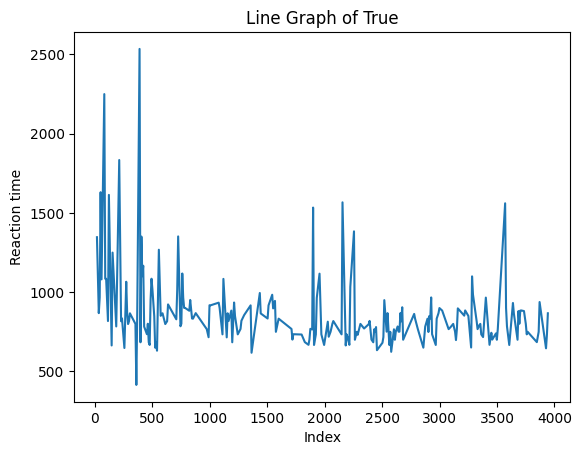

In [27]:
data=true_df.iloc[:,0]

# Create a line graph
data.plot(kind='line')
plt.title('Line Graph of True')
plt.xlabel('Index')
plt.ylabel('Reaction time')
plt.show()

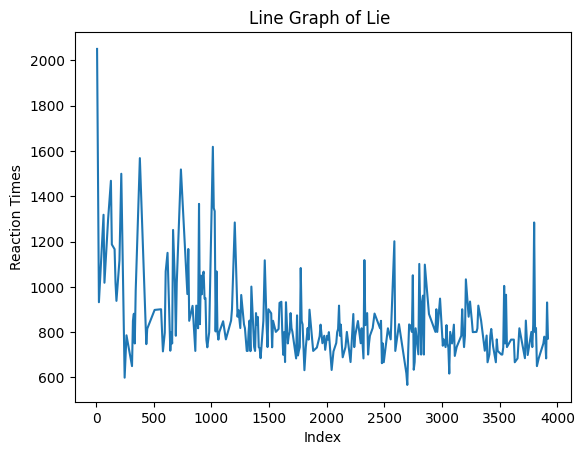

In [28]:
data=lie_df.iloc[:,0]

# Create a line graph
data.plot(kind='line')
plt.title('Line Graph of Lie ')
plt.xlabel('Index')
plt.ylabel('Reaction Times')
plt.show()

In [29]:
true_df[1].describe()

,1
count,220.000000
mean,862.813636
std,242.586833
min,415.000000
25%,734.000000
50%,807.500000
75%,900.250000
max,2535.000000


In [30]:
lie_df[1].describe()

,1
count,264.000000
mean,851.181818
std,188.351073
min,567.000000
25%,734.000000
50%,801.000000
75%,898.250000
max,2050.000000


In [31]:
n=filter(updated_df_tf,'3',['cardT','cardL','cardS','playerinput_True_1', 'playerinput_True_2', 'playerinput_True_3', 'playerinput_True_4', 'playerinput_True_5', 'playerinput_True_6','playerinput_Lie_1', 'playerinput_Lie_2', 'playerinput_Lie_3', 'playerinput_Lie_4', 'playerinput_Lie_5', 'playerinput_Lie_6' ])
n


,1,3
7,2001.0,cardL
9,2050.0,playerinput_Lie_4
15,2020.0,cardT
17,1347.0,playerinput_True_4
23,2014.0,cardS
...,...,...
3927,646.0,playerinput_True_3
3933,2014.0,cardT
3935,734.0,playerinput_True_3
3941,2015.0,cardS


In [32]:
card=['cardT', 'cardL', 'cardS']
df=n
# Process the DataFrame to associate each player input with its preceding type
processed_data = []
current_type = None

for _, row in df.iterrows():
    if row['3'] in card:
        current_type = row['3']
        processed_data.append((row[1], current_type, None))
    else:
        processed_data.append((row[1], current_type, row['3']))

# Convert to DataFrame
processed_df = pd.DataFrame(processed_data, columns=['Time (ms)', 'Type', 'Player Input'])

# Display the processed DataFrame
print("Processed DataFrame:")
print(processed_df)

Processed DataFrame:
     Time (ms)   Type        Player Input
0       2001.0  cardL                None
1       2050.0  cardL   playerinput_Lie_4
2       2020.0  cardT                None
3       1347.0  cardT  playerinput_True_4
4       2014.0  cardS                None
..         ...    ...                 ...
969      646.0  cardS  playerinput_True_3
970     2014.0  cardT                None
971      734.0  cardT  playerinput_True_3
972     2015.0  cardS                None
973      867.0  cardS  playerinput_True_6

[974 rows x 3 columns]


In [33]:
# Function to filter rows by type
def filter_by_type(df, player_type):
    return df[df['Type'] == player_type]

# Filter rows for type 'cardS'
filtered_cardS = filter_by_type(processed_df, 'cardS')
filtered_cardT = filter_by_type(processed_df, 'cardT')
filtered_cardL = filter_by_type(processed_df, 'cardL')

In [34]:
filtered_cardS = filter_by_type(processed_df, 'cardS')
filtered_cardS

,Time (ms),Type,Player Input
4,2014.0,cardS,None
5,932.0,cardS,playerinput_Lie_2
6,2023.0,cardS,None
7,868.0,cardS,playerinput_True_4
8,2030.0,cardS,None
...,...,...,...
957,750.0,cardS,playerinput_Lie_6
968,2011.0,cardS,None
969,646.0,cardS,playerinput_True_3
972,2015.0,cardS,None


In [35]:

df=filtered_cardS
# Assuming df is your DataFrame
def filter_by_player_input(df, player_input):
    # Filter for player input containing 'playerinput_True_' or 'playerinput_Lie_'
    filtered_df = df[df['Player Input'].str.contains(f'playerinput_{player_input}_', na=False)]
    return filtered_df

# Filter for 'playerinput_True_'
filtered_Strue = filter_by_player_input(df, 'True')
print("Filtered DataFrame for playerinput_True_:")
print(filtered_Strue)

# Filter for 'playerinput_Lie_'
filtered_Slie = filter_by_player_input(df, 'Lie')
print("\nFiltered DataFrame for playerinput_Lie_:")
print(filtered_Slie)

Filtered DataFrame for playerinput_True_:
     Time (ms)   Type        Player Input
7        868.0  cardS  playerinput_True_4
9        968.0  cardS  playerinput_True_4
19      2250.0  cardS  playerinput_True_5
37      1250.0  cardS  playerinput_True_5
45       784.0  cardS  playerinput_True_5
..         ...    ...                 ...
929      750.0  cardS  playerinput_True_6
953      750.0  cardS  playerinput_True_6
955      938.0  cardS  playerinput_True_4
969      646.0  cardS  playerinput_True_3
973      867.0  cardS  playerinput_True_6

[99 rows x 3 columns]

Filtered DataFrame for playerinput_Lie_:
     Time (ms)   Type       Player Input
5        932.0  cardS  playerinput_Lie_2
15      1318.0  cardS  playerinput_Lie_3
25      1301.0  cardS  playerinput_Lie_4
31      1468.0  cardS  playerinput_Lie_5
33      1187.0  cardS  playerinput_Lie_5
..         ...    ...                ...
935      834.0  cardS  playerinput_Lie_1
939      800.0  cardS  playerinput_Lie_4
941      818.0  card

In [36]:
filtered_cardT = filter_by_type(processed_df, 'cardT')
filtered_cardT

,Time (ms),Type,Player Input
2,2020.0,cardT,None
3,1347.0,cardT,playerinput_True_4
10,2016.0,cardT,None
11,1631.0,cardT,playerinput_True_1
12,2010.0,cardT,None
...,...,...,...
949,685.0,cardT,playerinput_True_3
950,2026.0,cardT,None
951,719.0,cardT,playerinput_True_2
970,2014.0,cardT,None


In [37]:
df=filtered_cardT
# Assuming df is your DataFrame
def filter_by_player_input(df, player_input):
    # Filter for player input containing 'playerinput_True_' or 'playerinput_Lie_'
    filtered_df = df[df['Player Input'].str.contains(f'playerinput_{player_input}_', na=False)]
    return filtered_df

# Filter for 'playerinput_True_'
filtered_Itrue = filter_by_player_input(df, 'True')
print("Filtered DataFrame for playerinput_True_:")
print(filtered_Itrue)

Filtered DataFrame for playerinput_True_:
     Time (ms)   Type        Player Input
3       1347.0  cardT  playerinput_True_4
11      1631.0  cardT  playerinput_True_1
13      1081.0  cardT  playerinput_True_4
21      1085.0  cardT  playerinput_True_6
23      1085.0  cardT  playerinput_True_4
..         ...    ...                 ...
915      885.0  cardT  playerinput_True_4
921      881.0  cardT  playerinput_True_6
949      685.0  cardT  playerinput_True_3
951      719.0  cardT  playerinput_True_2
971      734.0  cardT  playerinput_True_3

[121 rows x 3 columns]


In [38]:
filtered_cardL = filter_by_type(processed_df, 'cardL')
filtered_cardL


,Time (ms),Type,Player Input
0,2001.0,cardL,None
1,2050.0,cardL,playerinput_Lie_4
16,2024.0,cardL,None
17,1018.0,cardL,playerinput_Lie_3
46,2017.0,cardL,None
...,...,...,...
963,684.0,cardL,playerinput_Lie_3
964,2006.0,cardL,None
965,931.0,cardL,playerinput_Lie_4
966,2016.0,cardL,None


In [39]:
df=filtered_cardL
# Assuming df is your DataFrame
def filter_by_player_input(df, player_input):
    # Filter for player input containing 'playerinput_True_' or 'playerinput_Lie_'
    filtered_df = df[df['Player Input'].str.contains(f'playerinput_{player_input}_', na=False)]
    return filtered_df

# Filter for 'playerinput_True_'
filtered_Ilie = filter_by_player_input(df, 'Lie')
print("Filtered DataFrame for playerinput_Lie_:")
print(filtered_Ilie)

Filtered DataFrame for playerinput_Lie_:
     Time (ms)   Type       Player Input
1       2050.0  cardL  playerinput_Lie_4
17      1018.0  cardL  playerinput_Lie_3
49      1117.0  cardL  playerinput_Lie_2
53      1499.0  cardL  playerinput_Lie_5
60       599.0  cardL  playerinput_Lie_6
..         ...    ...                ...
959      780.0  cardL  playerinput_Lie_4
961      767.0  cardL  playerinput_Lie_6
963      684.0  cardL  playerinput_Lie_3
965      931.0  cardL  playerinput_Lie_4
967      772.0  cardL  playerinput_Lie_4

[121 rows x 3 columns]


In [40]:
filtered_Strue['Time (ms)']

,Time (ms)
7,868.0
9,968.0
19,2250.0
37,1250.0
45,784.0
...,...
929,750.0
953,750.0
955,938.0
969,646.0


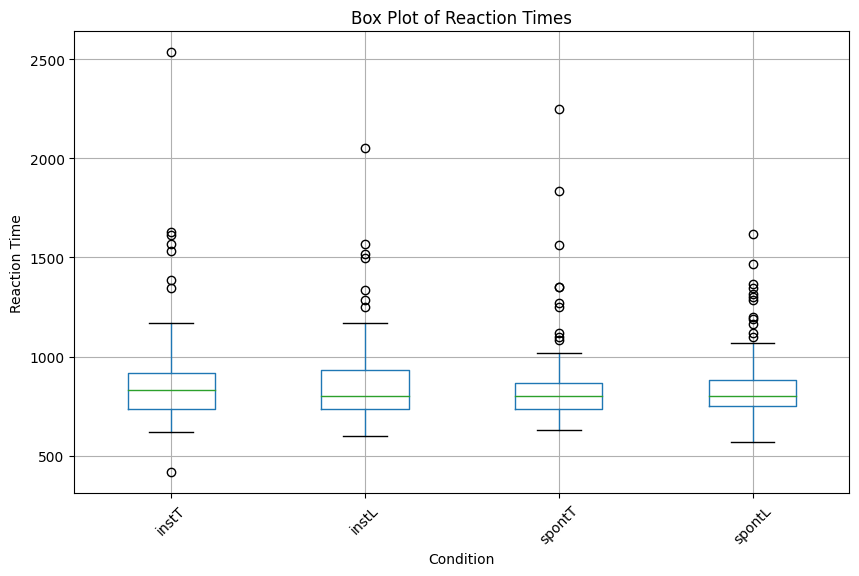

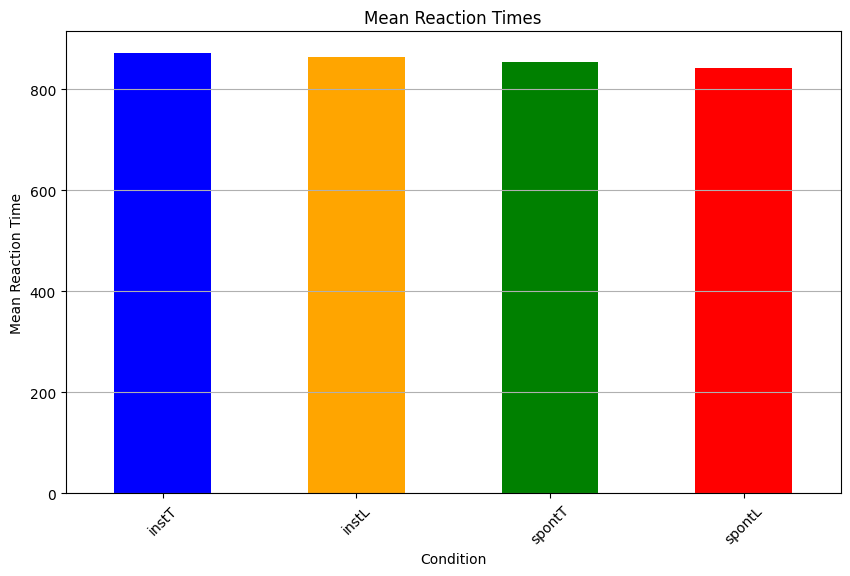

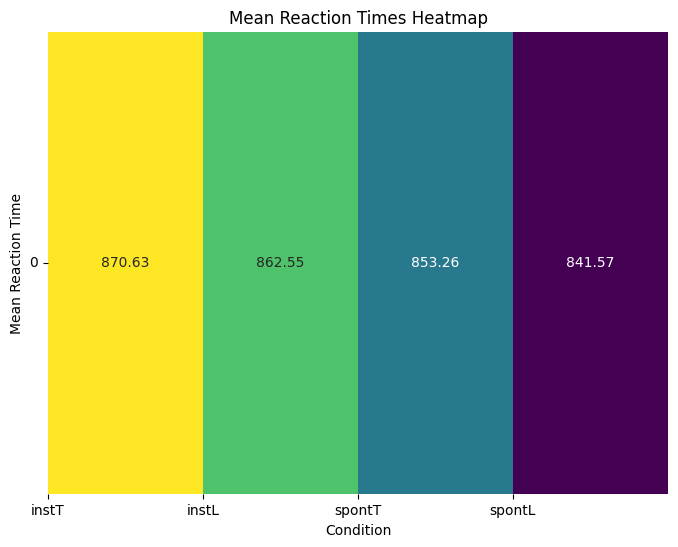

In [41]:

#box plot
data = {
    'instT': filtered_Itrue['Time (ms)'],
    'instL': filtered_Ilie['Time (ms)'],
    'spontT': filtered_Strue['Time (ms)'],
    'spontL': filtered_Slie['Time (ms)']
}
df = pd.DataFrame(data)

# Create a box plot
plt.figure(figsize=(10, 6))
df.boxplot()
plt.title('Box Plot of Reaction Times')
plt.ylabel('Reaction Time')
plt.xlabel('Condition')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plotting the bar plot
plt.figure(figsize=(10, 6))
df.mean().plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.title('Mean Reaction Times')
plt.ylabel('Mean Reaction Time')
plt.xlabel('Condition')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


#heatmap
# Calculate the mean reaction times for each condition
mean_reaction_times = df.mean()

# Reshape the data for the heatmap
heatmap_data = mean_reaction_times.values.reshape(1, -1)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".2f", cbar=False)
plt.title('Mean Reaction Times Heatmap')
plt.xlabel('Condition')
plt.ylabel('Mean Reaction Time')
plt.xticks(ticks=range(len(mean_reaction_times)), labels=mean_reaction_times.index)
plt.yticks(rotation=0)
plt.show()

**Reaction Time Analysis**

In [42]:
#timestamp analysis


def timestampcardfilter(timestamp_log_upd):
    t=timestamp_log_upd.iloc[:,1]
    # Convert the timestamp column to datetime
    df= pd.to_datetime(t,format='%H:%M:%S.%f').dt.time

    # To perform calculations, convert to timedelta from the start of the day
    df = pd.to_timedelta(df.astype(str))

    # Calculate the time difference between consecutive rows
    df_tf = df.diff().dt.total_seconds() * 1000

    updated_df_tf=pd.concat([df_tf,timestamp_log_upd.iloc[:,3]], axis=1)

    def filter(df, column, categorylist):
      filterdf=df[df[column].isin(categorylist)]
      return filterdf

    #updated_df_tf_filtered=updated_df_tf[updated_df_tf['3'].isin(['round','result_trial_point_status'])]
    updated_df_tf_filtered=filter(updated_df_tf,'3',['cardT', 'cardL','cardS'])
    #updated_df_tf_filtered.head(46)

    #filtering true
    true_df=filter(updated_df_tf,'3',['playerinput_True_1', 'playerinput_True_2', 'playerinput_True_3', 'playerinput_True_4', 'playerinput_True_5', 'playerinput_True_6'])
    #true_df['3'].value_counts()

    #filtering false
    lie_df=filter(updated_df_tf,'3',['playerinput_Lie_1', 'playerinput_Lie_2', 'playerinput_Lie_3', 'playerinput_Lie_4', 'playerinput_Lie_5', 'playerinput_Lie_6'])
    #lie_df['3'].value_counts()

    n=filter(updated_df_tf,'3',['cardT','cardL','cardS','playerinput_True_1', 'playerinput_True_2', 'playerinput_True_3', 'playerinput_True_4', 'playerinput_True_5', 'playerinput_True_6','playerinput_Lie_1', 'playerinput_Lie_2', 'playerinput_Lie_3', 'playerinput_Lie_4', 'playerinput_Lie_5', 'playerinput_Lie_6' ])
    #n

    card=['cardT', 'cardL', 'cardS']
    df=n
    # Process the DataFrame to associate each player input with its preceding type
    processed_data = []
    current_type = None

    for _, row in df.iterrows():
        if row['3'] in card:
            current_type = row['3']
            processed_data.append((row[1], current_type, None))
        else:
            processed_data.append((row[1], current_type, row['3']))

    # Convert to DataFrame
    processed_df = pd.DataFrame(processed_data, columns=['Time (ms)', 'Type', 'Player Input'])

    # Display the processed DataFrame
    #print("Processed DataFrame:")
    #print(processed_df)

    # Function to filter rows by type
    def filter_by_type(df, player_type):
        return df[df['Type'] == player_type]

    # Filter rows for type 'cardS'
    filtered_cardS = filter_by_type(processed_df, 'cardS')
    filtered_cardT = filter_by_type(processed_df, 'cardT')
    filtered_cardL = filter_by_type(processed_df, 'cardL')
    return filtered_cardT, filtered_cardL, filtered_cardS

def filter_by_player_input(df, player_input):
        # Filter for player input containing 'playerinput_True_' or 'playerinput_Lie_'
        filtered_df = df[df['Player Input'].str.contains(f'playerinput_{player_input}_', na=False)]
        return filtered_df


In [43]:
cardT, cardL, cardS=timestampcardfilter(timestamp_log_upd)
cardStrue=filter_by_player_input(cardS, 'True')
cardSlie=filter_by_player_input(cardS, 'Lie')

Itrue = filter_by_player_input(cardT, 'True').iloc[:,0]
Ilie = filter_by_player_input(cardL, 'Lie').iloc[:,0]
Strue=cardStrue['Time (ms)']
Slie=cardSlie['Time (ms)']

In [44]:
def timestampfiles(n):

    def get_filtered_files(folder_path):
        # Regular expression pattern to match the required file format
        pattern = re.compile(r'Player_(sub\d+)_Observer_(sub\d+)_Timestamp\.txt')

        # Dictionary to store the filtered files
        filtered_files = {}

        # Check if the folder exists
        if not os.path.isdir(folder_path):
            print(f"The folder '{folder_path}' does not exist.")
            return filtered_files

        # Iterate over files in the specified folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):
                match = pattern.match(filename)
                if match:
                    player_id = match.group(1)
                    p_key = f"p{int(player_id[3:])}"  # Convert subXX to pX
                    if p_key not in filtered_files:
                        filtered_files[p_key] = []
                    # Store the file path in the dictionary
                    filtered_files[p_key].append(os.path.join(folder_path, filename))

        return filtered_files

    def get_key_list(filtered_files):
        # Return the list of keys
        return list(filtered_files.keys())

    def get_specific_files(filtered_files, key):
        # Return the list of files for the specified key
        return filtered_files.get(key, [])

    # Specify the folder containing the .txt files
    folder_path = '/content/drive/MyDrive/thesisdata/eegdataset/24760827eeg/behavioral log and trigger timestamp'

    # Get the filtered files
    filtered_files = get_filtered_files(folder_path)

    # Get the list of keys
    keys = get_key_list(filtered_files)

    # Print the list of keys
    #print("List of keys:", keys)

    # Get specific files for a key, e.g., p1
    keys = [f'p{i}' for i in range(1, 25) if i != 2]
    key_to_retrieve = keys[n]
    specific_files = get_specific_files(filtered_files, key_to_retrieve)

    # Print the files for the specified key
    #print(f"\nFiles for {key_to_retrieve}:")
    for file in specific_files:
        #print(f"  {file}")
        return  file


In [45]:
timestampfiles(1)

'/content/drive/MyDrive/thesisdata/eegdataset/24760827eeg/behavioral log and trigger timestamp/Player_sub03_Observer_sub06_Timestamp.txt'

In [46]:

def timestampdataformat(timestamptxt):
    try:
        timestamp_log = pd.read_fwf(timestamptxt, sep=" ", header=None)
        # Split the specific column
        split_data = timestamp_log[2].str.split(' ', n=1, expand=True)
        # Rename the split columns
        split_data.columns = ['2', '3']
        # Concatenate the original DataFrame with the split columns
        timestamp_log_n = timestamp_log
        timestamp_log_n.drop(columns=[2], inplace=True)
        timestamp_log_upd = pd.concat([timestamp_log_n, split_data], axis=1)
        return timestamp_log_upd
    except FileNotFoundError:
        print(f"File not found: {timestamptxt}")
        return None

In [47]:
timestampdataformat(timestampfiles(2))

,0,1,2,3
0,2018-09-17,14:54:14.288000,1.67350959171,init_cedruspad
1,2018-09-17,14:54:15.762000,3.146717706,experiment_start
2,2018-09-17,14:54:29.078000,1.60601900723,init_cedruspad
3,2018-09-17,14:54:31.212000,3.74077730577,experiment_start
4,2018-09-17,14:54:31.570000,4.09815273551,welcome
...,...,...,...,...
3950,2018-09-17,16:14:52.268000,4824.75470641,result_trial_observer_incorrect
3951,2018-09-17,16:14:53.295000,4825.7817948,result_trial_point_status
3952,2018-09-17,16:14:55.272000,4827.75940445,result_round_observer_lose
3953,2018-09-17,16:14:56.322000,4828.80930996,result_final_observer_lose


In [48]:

def timestampupdated_analysis(num):
    timestamp_log_upd=timestampdataformat(timestampfiles(num))
    cardT, cardL, cardS=timestampcardfilter(timestamp_log_upd)
    cardStrue=filter_by_player_input(cardS, 'True')
    cardSlie=filter_by_player_input(cardS, 'Lie')

    Itrue = filter_by_player_input(cardT, 'True').iloc[:,0]
    Ilie = filter_by_player_input(cardL, 'Lie').iloc[:,0]
    Strue=cardStrue['Time (ms)']
    Slie=cardSlie['Time (ms)']

    return [cardT, cardL, cardS, cardStrue, cardSlie, Itrue, Ilie, Strue, Slie]

In [49]:
test=timestampupdated_analysis(22)[6]
test

,Time (ms)
1,1158.0
13,644.0
17,526.0
19,644.0
25,483.0
...,...
1085,1235.0
1093,684.0
1129,935.0
1131,917.0


In [50]:
def combine_participant_data():
    # Example data for demonstration (replace these with your actual data)
    participant_data = []

    # Assuming you have 23 participants
    for participant_id in range(0, 23):
        # Assuming each participant's pandas Series data can be accessed by timestampupdated_analysis(participant_num)
        # Replace these with your actual function call to retrieve the pandas Series data for each participant
        series_data = [timestampupdated_analysis(participant_id)[series_num] for series_num in range(5,9)]

        # Transpose the Series data
        transposed_series_data = [series.values.tolist() for series in series_data]

        # Append the participant number and transposed Series data for the current participant to the list
        participant_data.append([participant_id] + transposed_series_data)

    # Create a DataFrame from the participant data
    df = pd.DataFrame(participant_data, columns=['Participant'] + [f'Series_{i+1}' for i in range(4)])
    # Create a DataFrame from the participant data
    df = pd.DataFrame(participant_data, columns=['Participant', 'instT', 'instL', 'sponT', 'sponL'])

    return df

# Example usage:
combined_df = combine_participant_data()
#print(combined_df)

In [51]:
combined_df.iloc[0:2]

,Participant,instT,instL,sponT,sponL
0,0,"[1347.0, 1631.0, 1081.0, 1085.0, 1085.0, 818.0...","[2050.0, 1018.0, 1117.0, 1499.0, 599.0, 786.0,...","[868.0, 968.0, 2250.0, 1250.0, 784.0, 1834.0, ...","[932.0, 1318.0, 1301.0, 1468.0, 1187.0, 1166.0..."
1,1,"[427.0, 417.0, 518.0, 259.0, 540.0, 268.0, 359...","[1168.0, 642.0, 317.0, 451.0, 318.0, 402.0, 45...","[551.0, 642.0, 451.0, 685.0, 351.0, 468.0, 367...","[576.0, 1077.0, 600.0, 2910.0, 585.0, 509.0, 4..."


In [52]:
timestampupdated_analysis(1)[6]

,Time (ms)
3,1168.0
13,642.0
29,317.0
31,451.0
41,318.0
...,...
932,476.0
946,317.0
952,402.0
960,301.0


**HEAT MAP**

In [53]:

data=combined_df
# Create a new DataFrame to store the mean values
mean_df = pd.DataFrame({'Participant': data['Participant']})

# Calculate the mean of each list for each participant and add to the new DataFrame
for col in data.keys():
    if col != 'Participant':
        mean_df[col] = [sum(lst) / len(lst) for lst in data[col]]

print(mean_df)

    Participant       instT        instL       sponT        sponL
0             0  870.628099   862.545455  853.262626   841.566434
1             1  404.628099   414.553719  373.764706   464.977528
2             2  374.975410   352.561983  335.569343   377.390476
3             3  807.852459   660.456000  789.860000   892.610526
4             4  559.694215   543.925620  572.079646   566.302326
5             5  776.117188   813.353846  989.104478   897.083333
6             6  904.256198   862.528926  979.895425   991.677083
7             7  876.983471   779.229508  827.220339   797.314516
8             8  587.867769   531.877049  516.481752   585.857143
9             9  692.198347   794.619835  746.039216   796.233333
10           10  562.925620   674.851240  618.093960   736.376344
11           11  658.454545   705.322314  692.046512   686.885965
12           12  809.975207   788.561983  857.719424   826.825243
13           13  352.115702   378.793388  327.753247   403.420455
14        

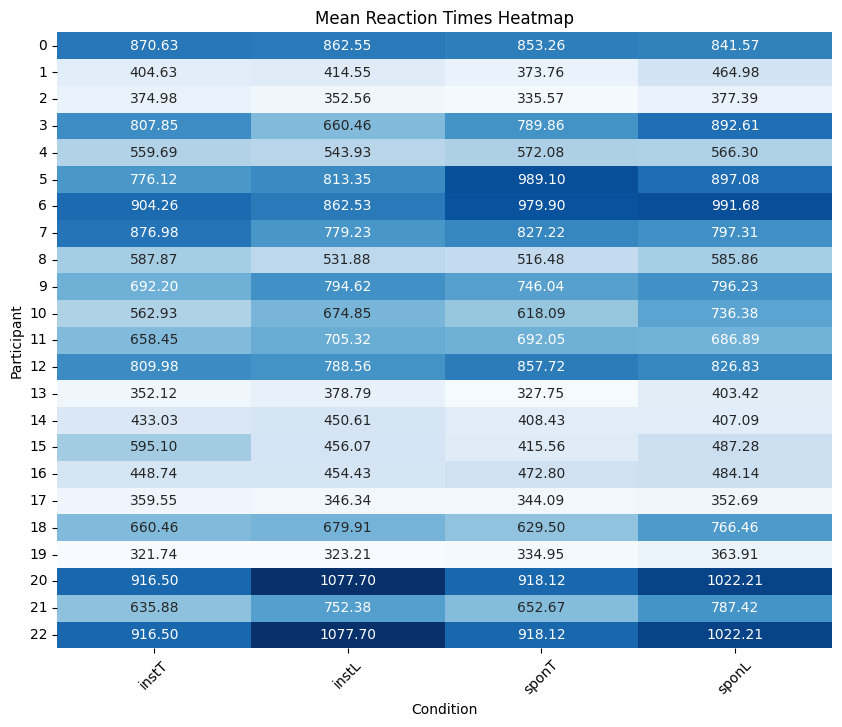

In [54]:
def create_heatmap(df):
     # Remove 'Participant' column
    df = df.set_index('Participant')

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, cmap='Blues', annot=True, fmt=".2f", cbar=False)
    plt.title('Mean Reaction Times Heatmap')
    plt.xlabel('Condition')
    plt.ylabel('Participant')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
create_heatmap(mean_df)

**BOX PLOT**

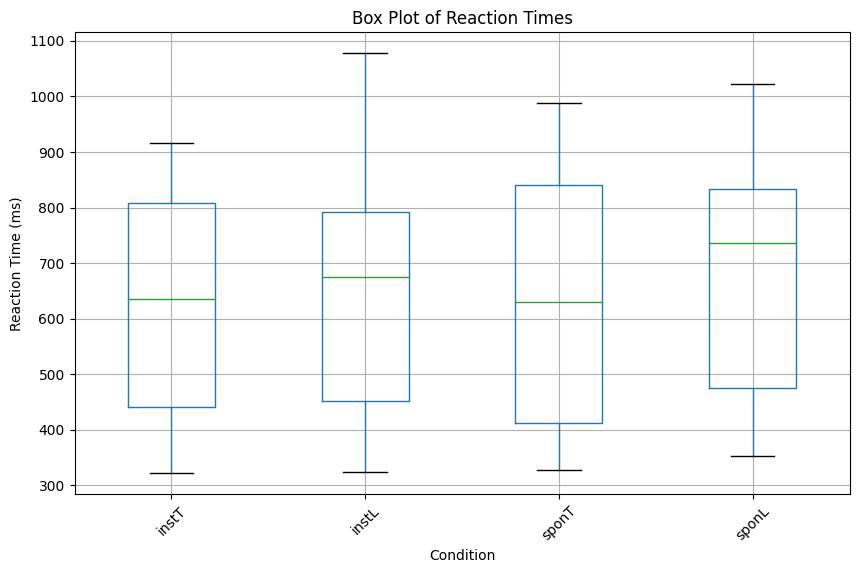

In [55]:

df=mean_df.iloc[:,1:]

# Create a box plot
plt.figure(figsize=(10, 6))
df.boxplot()
plt.title('Box Plot of Reaction Times')
plt.ylabel('Reaction Time (ms)')
plt.xlabel('Condition')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**Bar Plot**

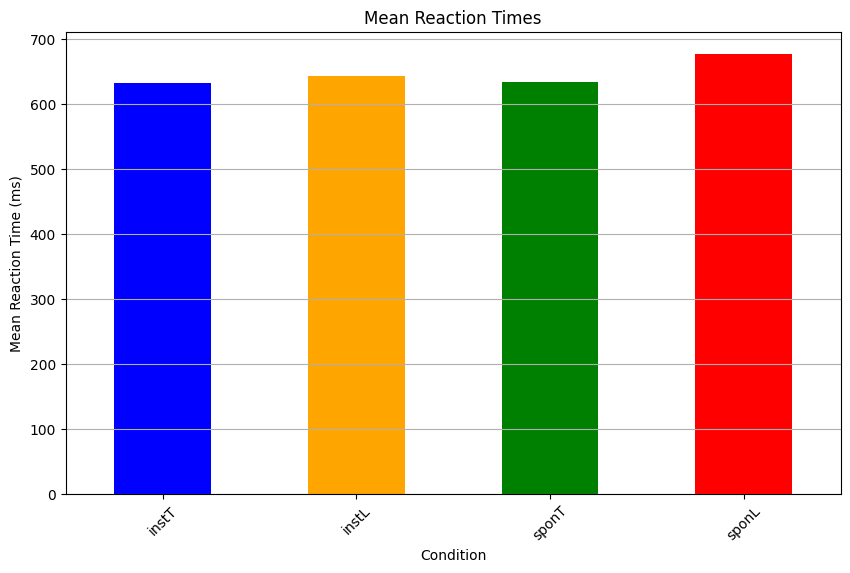

In [56]:

df=mean_df.iloc[:,1:]
# Plotting the bar plot
plt.figure(figsize=(10, 6))
df.mean().plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.title('Mean Reaction Times')
plt.ylabel('Mean Reaction Time (ms)')
plt.xlabel('Condition')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

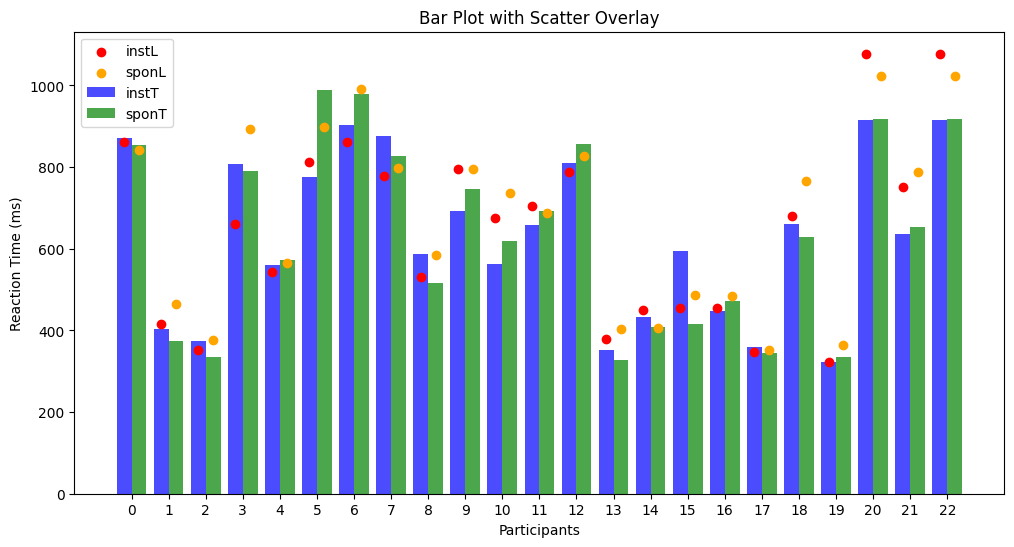

In [57]:

df=mean_df.iloc[:,1:]
# Set the figure size
plt.figure(figsize=(12, 6))

# Bar plot for instT and sponT
bar_width = 0.4
indices = df.index
bar1 = plt.bar(indices - bar_width/2, df['instT'], width=bar_width, label='instT', color='blue', alpha=0.7)
bar2 = plt.bar(indices + bar_width/2, df['sponT'], width=bar_width, label='sponT', color='green', alpha=0.7)

# Scatter plot for instL and sponL
plt.scatter(indices - bar_width/2, df['instL'], color='red', label='instL', zorder=5)
plt.scatter(indices + bar_width/2, df['sponL'], color='orange', label='sponL', zorder=5)

# Customize the plot
plt.xlabel('Participants')
plt.ylabel('Reaction Time (ms)')
plt.title('Bar Plot with Scatter Overlay')
plt.xticks(indices)
plt.legend()

# Show the plot
plt.show()

# ERP ANALYSIS

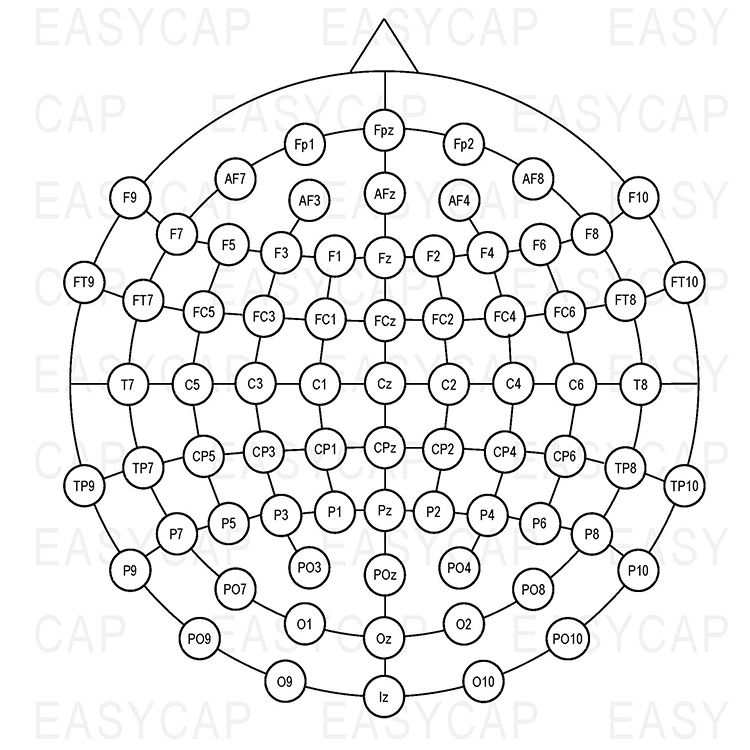

Easy cap EEG Channel location

In [58]:
ch_names=epos[0][0][0][2][0]

In [59]:
ch_names.tolist()

[array(['F7'], dtype='<U2'),
 array(['F3'], dtype='<U2'),
 array(['Fz'], dtype='<U2'),
 array(['F4'], dtype='<U2'),
 array(['F8'], dtype='<U2'),
 array(['FC5'], dtype='<U3'),
 array(['FC1'], dtype='<U3'),
 array(['FC2'], dtype='<U3'),
 array(['FC6'], dtype='<U3'),
 array(['T7'], dtype='<U2'),
 array(['C3'], dtype='<U2'),
 array(['Cz'], dtype='<U2'),
 array(['C4'], dtype='<U2'),
 array(['T8'], dtype='<U2'),
 array(['CP5'], dtype='<U3'),
 array(['CP1'], dtype='<U3'),
 array(['CP2'], dtype='<U3'),
 array(['CP6'], dtype='<U3'),
 array(['P7'], dtype='<U2'),
 array(['P3'], dtype='<U2'),
 array(['Pz'], dtype='<U2'),
 array(['P4'], dtype='<U2'),
 array(['P8'], dtype='<U2'),
 array(['PO3'], dtype='<U3'),
 array(['PO4'], dtype='<U3'),
 array(['O1'], dtype='<U2'),
 array(['O2'], dtype='<U2'),
 array(['F9'], dtype='<U2'),
 array(['F10'], dtype='<U3'),
 array(['Fp2'], dtype='<U3')]

In [60]:
def grand_average(channel_num):
  if channel_num in range(1,31):
      all_players_data = []

      # Iterate through all players and gather their data
      for p in range(len(epos)):
          df = player_df(p)
          all_players_data.append(df)

      # Combine all players' data into one DataFrame
      combined_df = pd.concat(all_players_data, ignore_index=True)

      # Initialize a dictionary to hold the grand average for each category
      grand_averages = {'sponL': [], 'sponT': [], 'instL': [], 'instT': []}

      # Calculate the grand average for each category
      for category in grand_averages.keys():
          category_data = combined_df[combined_df['category'] == category]

          # Collect all EEG lists for the specified channel across all trials for the current category
          all_eeg_lists = np.array(category_data[f'channel_{channel_num}'].tolist())

          # Calculate the grand average by taking the mean across the first dimension (trials)
          grand_averages[category] = np.mean(all_eeg_lists, axis=0)
  return grand_averages

def plot_erp(channel_num):
    if channel_num in range(1,31):
      grand_averages=grand_average(channel_num)

      # Extract timestamps
      timestamps = epos[0][0][0][5][0]  # Assuming timestamps are the same for all players

      # Define the range for x-axis in milliseconds
      x_range = (-100, 700)
      timestamps_ms = np.array(timestamps)  # Convert timestamps to milliseconds

      # Filter the timestamps and grand averages to include only the desired range
      valid_indices = np.where((timestamps_ms >= x_range[0]) & (timestamps_ms <= x_range[1]))[0]

      # Plot the grand averages
      plt.figure(figsize=(10, 6))
      color_cat={'sponL': 'blue', 'sponT': 'cyan' , 'instT': 'orange' , 'instL': 'red' }
      for category, data in grand_averages.items():
          #plt.plot(data, label=category)
          plt.plot(timestamps_ms[valid_indices], np.array(data)[valid_indices], label=category, color=color_cat[category])

      plt.title(f'Grand Average ERP for Channel {channel_num}[{ch_names[channel_num-1][0]}]')
      plt.xlabel('Time Points')
      plt.ylabel('EEG Amplitude')
      plt.legend()
      plt.grid(True)
      plt.show()

    else:
      print('Channel Num range: [1,30]')

In [ ]:
#grand_average(21)

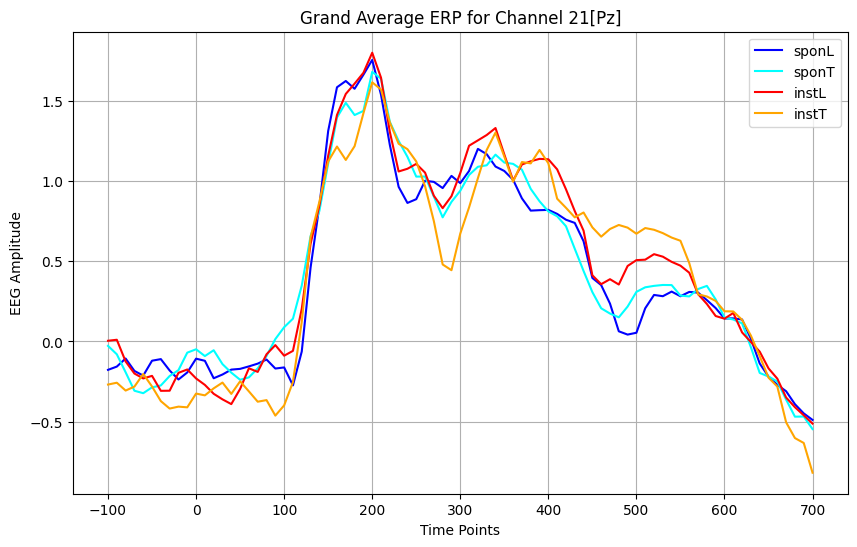

In [61]:
#plot_erp(21) #plotting for 21: Pz as it is widely used channel in deception detection. Modify to vizualise other channels.

In [62]:
def plot_all_channels():
    # Extract timestamps
    timestamps = epos[0][0][0][5][0]  # Assuming timestamps are the same for all players

    # Define the range for x-axis in milliseconds
    x_range = (-100, 700)
    timestamps_ms = np.array(timestamps)  # Convert timestamps to milliseconds

    # Filter the timestamps to include only the desired range
    valid_indices = np.where((timestamps_ms >= x_range[0]) & (timestamps_ms <= x_range[1]))[0]

    # Create subplots
    fig, axs = plt.subplots(6, 5, figsize=(20, 20))
    fig.suptitle('Grand Average ERP for All Channels')

    for channel_num in range(1, 31):
        grand_averages = grand_average(channel_num)

        row = (channel_num - 1) // 5
        col = (channel_num - 1) % 5
        ax = axs[row, col]

        color_cat={'sponL': 'blue', 'sponT': 'cyan' , 'instT': 'orange' , 'instL': 'red' }
        for category, data in grand_averages.items():
            ax.plot(timestamps_ms[valid_indices], np.array(data)[valid_indices], label=category, color=color_cat[category])

        ax.set_title(f'Channel {channel_num} [{ch_names[channel_num-1][0]}]')
        ax.set_xlabel('Time Points (ms)')
        ax.set_ylabel('EEG Amplitude')
        ax.legend()
        ax.grid(True)
        if channel_num == 1:
            ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#plot_all_channels()

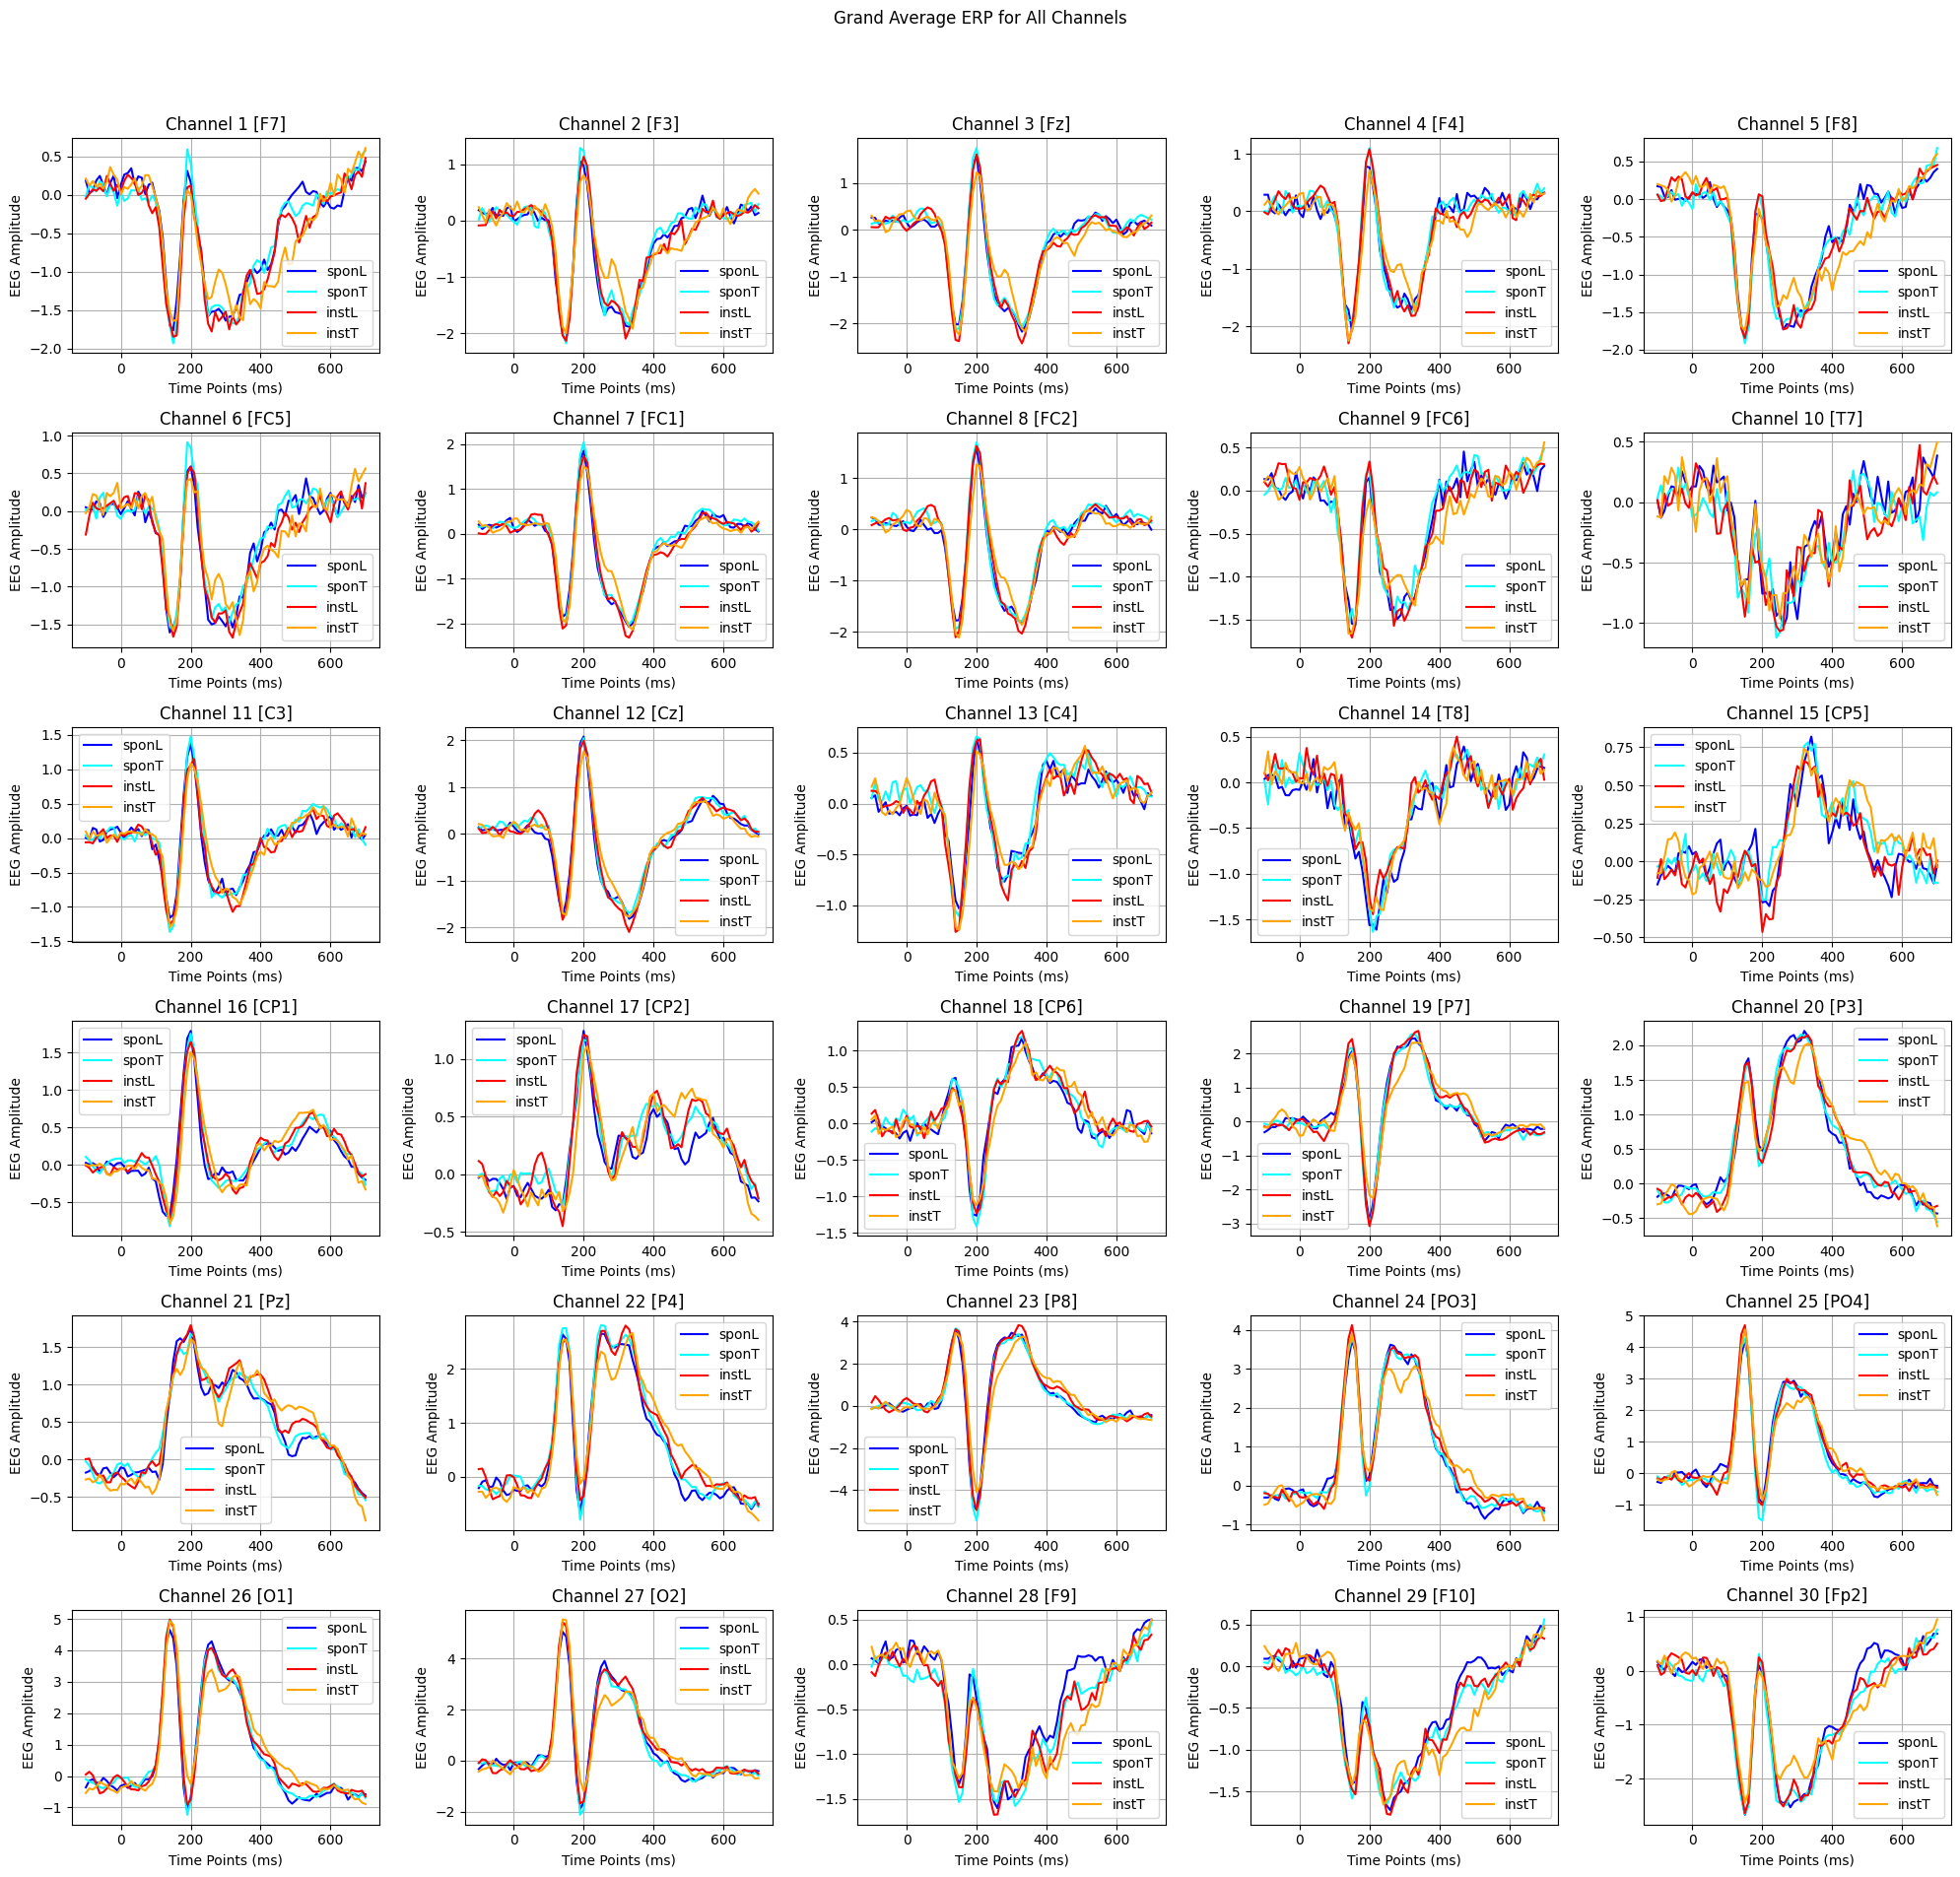

Above image attached to save the processing time.

As we can see Pz (Channel 21) does have some differences in minimum and  maximum average value and the gradient for the P300 (250 to 500 ms) range.

Similar observations can be made with some other channel, however it is not very conclusive.

# DATASET TRANSFORMATION

In [63]:
def dataset(channel_num):
  eeg=[]
  category=[]
  for player in range(23):
    df=player_df(player)
    category.append(df[df.columns[2]].values)
    eeg.append(df[df.columns[channel_num+2]].values)

  data={'x':eeg, 'y':category}
  return pd.DataFrame(data)

# Function to expand the DataFrame
def expand_dataframe(df):
    expanded_rows = []
    for player in range(23):  # Iterate over each player
      if player==19:trials=483
      elif player==21:trials=482
      else:trials=484
      for trial in range(trials):  # Iterate over each trial (484 trials)
            x_values = df.iloc[player, 0][trial]  # Extract the list of 350 values
            y_value = df.iloc[player, 1][trial]   # Extract the corresponding y value
            expanded_rows.append({'x': x_values, 'y': y_value})
    return pd.DataFrame(expanded_rows)

In [64]:
channel=21 #channel: 1 to 30
ch21=expand_dataframe(dataset(channel))
ch21

,x,y
0,"[1.322716236114502, 2.994771718978882, 6.41149...",instL
1,"[-3.844251871109009, -3.7300541400909424, -2.4...",instT
2,"[-4.691122531890869, -1.633573293685913, -0.56...",sponL
3,"[3.3362035751342773, 5.152755260467529, 4.7315...",sponT
4,"[0.20543311536312103, -0.11058960109949112, -2...",sponT
...,...,...
11124,"[2.688664436340332, 5.636557102203369, 3.92807...",instL
11125,"[-0.6962383389472961, 1.46507728099823, -2.223...",instL
11126,"[-3.8817899227142334, 0.4896158277988434, 0.76...",sponT
11127,"[-0.06153459846973419, -3.9250741004943848, -1...",sponT


In [65]:
def p300_df(df):
    def time_window(l,u):
          # Extract timestamps
          timestamps = epos[0][0][0][5][0]  # Assuming timestamps are the same for all players

          # Define the range for x-axis in milliseconds
          x_range = (l, u)
          timestamps_ms = np.array(timestamps)  # Convert timestamps to milliseconds

          # Filter the timestamps to include only the desired range
          valid_indices = np.where((timestamps_ms >= x_range[0]) & (timestamps_ms <= x_range[1]))[0]

          return valid_indices

    def eeg_window(eeg, timewindow):
        eeg=[eeg[i] for i in time_window(timewindow[0],timewindow[1])]
        return eeg


    def mean(list):
      mean=sum(list)/len(list)
      return mean

    def erp_time_window(eeg_df, time_window):
      #eeg_df=dataset(channel_num)
      x=eeg_df['x']
      y=eeg_df['y']
      x_new=[]
      for i in range(len(x)):
        x_new.append((eeg_window(x[i],time_window)))

      eeg_df_n=pd.DataFrame({'x':x_new, 'y':y})
      return eeg_df_n

    return erp_time_window(df, [250, 500])           #range of P300 is taken as 250 to 500

In [66]:
ch21_p300=p300_df(expand_dataframe(dataset(21)))
ch21_p300

,x,y
0,"[-0.3757180869579315, 1.5885050296783447, 0.53...",instL
1,"[-2.4870445728302, 4.088906764984131, 3.310979...",instT
2,"[-4.7962517738342285, -1.4890989065170288, -1....",sponL
3,"[-6.236530303955078, -6.72092342376709, -5.495...",sponT
4,"[-2.0842483043670654, -1.3741694688796997, 1.1...",sponT
...,...,...
11124,"[-0.2080729752779007, -1.6513162851333618, -1....",instL
11125,"[-2.7477426528930664, -0.6444938778877258, -1....",instL
11126,"[-3.3445396423339844, 0.36243292689323425, -0....",sponT
11127,"[-0.43944233655929565, -2.3280997276306152, -5...",sponT


# STATISTICAL TEST

In statistical test, we will use channel 21 (Pz) for individual reference, however function codes are designed for analysis on any channel in the given channel range.

In [67]:
def plot_channel_boxplot(df, channel_number):
    """
    Plot a box plot of EEG values for a specific channel, categorized by label.

    Parameters:
    - df: DataFrame with columns 'x' (list of EEG values) and 'y' (labels).
    - channel_number: Integer, the channel number to analyze (1-based index).

    Returns:
    - None: Displays a box plot with different colors for each label.
    """
    if channel_number < 1 or channel_number > 30:
        raise ValueError("Channel number must be between 1 and 30.")
    else:
      # Ensure that 'x' is a list of lists
      if not isinstance(df['x'].iloc[0], list):
          raise ValueError("'x' column must contain lists of EEG values.")

      # Convert 1-based index to 0-based index
      channel_index = channel_number - 1

      # Check if channel_index is within the range of EEG data
      if any(len(x) <= channel_index for x in df['x']):
          raise ValueError(f"Channel number {channel_number} is out of range for some EEG data.")

      # Extract EEG values for the specified channel
      df['channel_value'] = df['x'].apply(lambda x: x[channel_index])

      # Prepare data for plotting
      grouped_data = df.groupby('y')['channel_value'].apply(list)

      # Create a box plot
      plt.figure(figsize=(10, 6))

      # Plot boxplot
      plt.boxplot(grouped_data, labels=grouped_data.index, patch_artist=True)

      # Customize plot
      plt.xlabel('Labels')
      plt.ylabel(f'EEG Values for Channel {channel_number}')
      plt.title(f'Box Plot of EEG Values for Channel {channel_number} by Label')
      plt.grid(True)
      plt.show()



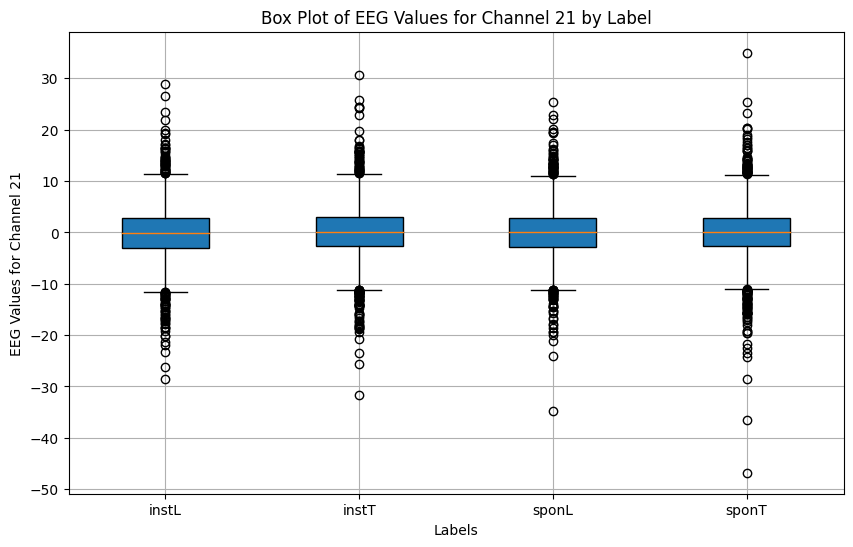

In [68]:
df=expand_dataframe(dataset(channel))
channel_number=21
plot_channel_boxplot(df, channel_number)

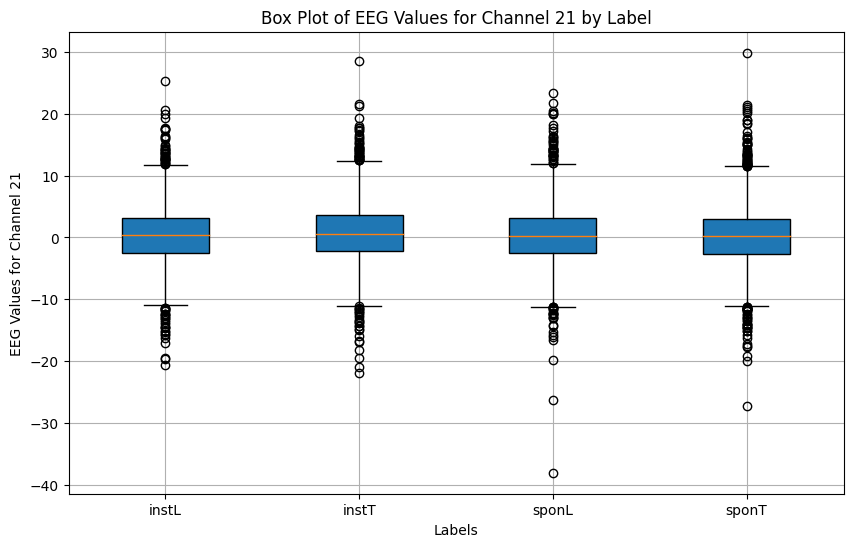

In [69]:
df=p300_df(expand_dataframe(dataset(channel)))
channel_number=21
plot_channel_boxplot(df, channel_number)

In [70]:
def plot_distribution_of_means(df):
    # Calculate the mean of each row in the 'x' column
    df['x_mean'] = df['x'].apply(np.mean)

    # Plot the distribution of means for each category in 'y'
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='x_mean', hue='y', kde=True, bins=30)
    plt.title('Distribution of Means for Each Category')
    plt.xlabel('Mean of x')
    plt.ylabel('Density')
    plt.show()

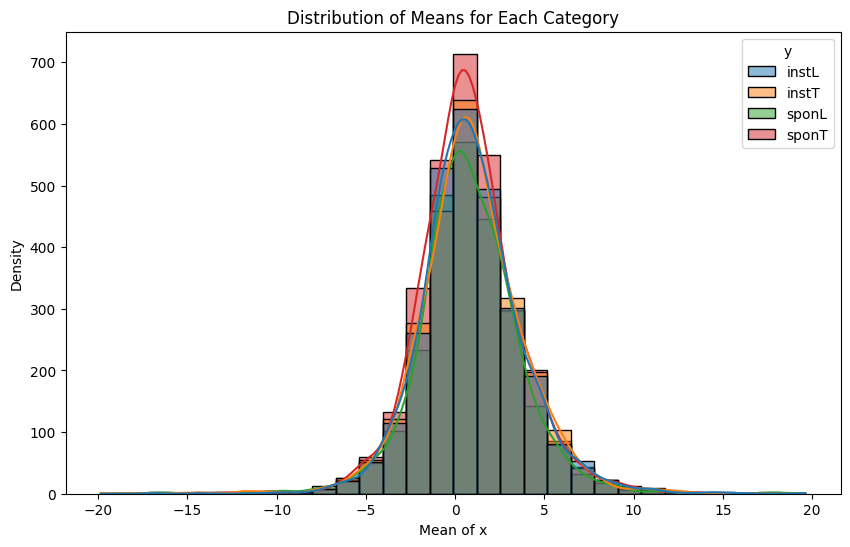

In [71]:
plot_distribution_of_means(ch21_p300)

In [72]:
from scipy.stats import shapiro

def check_normality(df):
    df['x_mean'] = df['x'].apply(np.mean)
    results = {}

    for category in df['y'].unique():
        data = df[df['y'] == category]['x_mean']
        stat, p_value = shapiro(data)
        results[category] = {'statistic': stat, 'p_value': p_value}

    # Output normality test results
    for category, result in results.items():
        print(f"Category: {category}, Shapiro-Wilk Test Statistic: {result['statistic']:.4f}, p-value: {result['p_value']:.4f}")
        if result['p_value'] < 0.05:
            print(f"Data in category {category} seems to be normally distributed (reject H0).")
        else:
            print(f"Data in category {category} does not seem to be normally distributed (fail to reject H0).")

In [73]:
check_normality(ch21_p300)

Category: instL, Shapiro-Wilk Test Statistic: 0.9709, p-value: 0.0000
Data in category instL seems to be normally distributed (reject H0).
Category: instT, Shapiro-Wilk Test Statistic: 0.9672, p-value: 0.0000
Data in category instT seems to be normally distributed (reject H0).
Category: sponL, Shapiro-Wilk Test Statistic: 0.9629, p-value: 0.0000
Data in category sponL seems to be normally distributed (reject H0).
Category: sponT, Shapiro-Wilk Test Statistic: 0.9743, p-value: 0.0000
Data in category sponT seems to be normally distributed (reject H0).


======= t -test for 4 classes===============

In [77]:
def perform_t_tests(channel_nums):
    results_columns = ['channel_num']
    results = pd.DataFrame(columns=results_columns)

    for channel in channel_nums:
        df = p300_df(expand_dataframe(dataset(channel)))

        # Debugging print statements
        #print(f"Processing channel: {channel}")
        #print(f"DataFrame structure:\n{df.head()}")

        if 'y' not in df.columns or 'x' not in df.columns:
            raise ValueError(f"The DataFrame for channel {channel} is missing 'x' or 'y' columns.")

        categories = df['y'].unique()
        row = {'channel_num': channel}

        if len(results_columns) == 1:
            results_columns += [f'{pair[0]} vs {pair[1]}' for pair in combinations(categories, 2)]
            results = pd.DataFrame(columns=results_columns)

        for pair in combinations(categories, 2):
            group1_means = df[df['y'] == pair[0]]['x'].apply(np.mean)
            group2_means = df[df['y'] == pair[1]]['x'].apply(np.mean)

            # Debugging print statements
            #print(f"Comparing: {pair[0]} vs {pair[1]}")
            #print(f"Group 1 means:\n{group1_means}")
            #print(f"Group 2 means:\n{group2_means}")

            t_stat, p_value = ttest_ind(group1_means, group2_means)
            row[f'{pair[0]} vs {pair[1]}'] = 1 if p_value < 0.05 else 0
        print(f'channel {channel}done')

        # Convert the row to a DataFrame and concatenate it with the results
        row_df = pd.DataFrame([row])
        results = pd.concat([results, row_df], ignore_index=True)


    return results

In [75]:
channel_nums = [i for i in range(1,31)]
result_t_test= perform_t_tests(channel_nums)

channel 1done
channel 2done
channel 3done
channel 4done
channel 5done
channel 6done
channel 7done
channel 8done
channel 9done
channel 10done
channel 11done
channel 12done
channel 13done
channel 14done
channel 15done
channel 16done
channel 17done
channel 18done
channel 19done
channel 20done
channel 21done
channel 22done
channel 23done
channel 24done
channel 25done
channel 26done
channel 27done
channel 28done
channel 29done
channel 30done


In [76]:
print('1 if significant difference in mean, else 0')
result_t_test

1 if significant difference in mean, else 0


,channel_num,instL vs instT,instL vs sponL,instL vs sponT,instT vs sponL,instT vs sponT,sponL vs sponT
0,1,0,0,0,1,1,0
1,2,0,0,0,0,0,0
2,3,0,0,0,0,0,0
3,4,0,0,0,0,0,0
4,5,0,0,0,0,0,0
5,6,0,0,1,0,1,0
6,7,1,0,1,0,0,0
7,8,0,0,0,0,0,0
8,9,0,0,1,0,1,0
9,10,0,0,0,0,0,0


T-test for all the channels in P300 range to compare means provides some insight on the effectiveness of different channels to classify the deception classes.


However, as can be seen from the table, this approach is not fully reliable.

# Pipeline

In [78]:
def create_dflist():
    print("Creating list of dataframes")
    df=[]
    for channel in selected_channels:
      d=p300_df(expand_dataframe(dataset(channel)))
      df.append(d)
      print(f"channel {channel} done")

    print("List of dataframes done")
    return df

def create_2dflist():
    innocent = ['instT', 'sponT']  # Add the class labels you consider "innocent"
    guilty = ['instL']    # Add the class labels you consider "guilty"

    print("Creating list of dataframes")
    df=[]
    for channel in selected_channels:
      d=p300_df(expand_dataframe(dataset(channel)))
      #df.append(d)

      # Ensure the column 'y' exists
      if 'y' not in d.columns:
          raise KeyError("The DataFrame does not have a 'y' column. Please check the column names.")

      # Define the mapping function
      def map_class(y):
          if y in innocent:
             return 'innocent'
          elif y in guilty:
             return 'guilty'
          else:
             return 'unknown'  # Handle cases where y is not in either list

      # Apply the mapping to the 'y' column
      d['y'] = d['y'].apply(map_class)
      df.append(d)

      print(f"channel {channel} done")

    print("List of dataframes done")
    return df


In [79]:
#=====================================Feature Extraction=====================================================================================

# Bispectrum calculation functions
# Convert string to array (as provided)
def convert_string_to_array(string):
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", string)
    return np.array(numbers, dtype=np.float64)

def compute_third_order_cumulant(signal_segment):
    N = len(signal_segment)
    C3 = np.zeros((N, N), dtype=np.complex128)

    for n1 in range(N):
        for n2 in range(N):
            C3[n1, n2] = np.mean(signal_segment * np.roll(signal_segment, n1) * np.roll(signal_segment, n2))

    return C3

def compute_bispectrum(C3):
    return fft2(C3)

def extract_statistical_features(bispectrum):
    T1, T2 = bispectrum.shape
    bispectrum_flat = np.abs(bispectrum).flatten()

    mean_bispectrum = np.mean(bispectrum_flat)
    variance_bispectrum = np.var(bispectrum_flat)
    skewness_bispectrum = skew(bispectrum_flat)
    kurtosis_bispectrum = kurtosis(bispectrum_flat)

    return mean_bispectrum, variance_bispectrum, skewness_bispectrum, kurtosis_bispectrum

def bispectrum_feature_extraction(df, segment_length=26, overlap=0, fs=1):
    data = []

    segment_samples = segment_length
    overlap_samples = overlap

    #print("Segment samples:", segment_samples)
    #print("Overlap samples:", overlap_samples)

    for index, row in df.iterrows():
        eeg_signal = np.array(row['x'])  # Convert the list of EEG values to a numpy array
        label = row['y']  # Label is a string

        #print(f"\nProcessing row {index} with label: {label}")
        #print("EEG signal length:", len(eeg_signal))

        if len(eeg_signal) < segment_samples:
            print(f"EEG signal length ({len(eeg_signal)}) is shorter than the segment length ({segment_samples}).")
            continue

        # Use full signal as segment if shorter than segment length
        start = 0
        while start + segment_samples <= len(eeg_signal):
            segment = eeg_signal[start:start + segment_samples]

            #print(f"Segment start index: {start}, end index: {start + segment_samples}")
            #print("Segment length:", len(segment))

            # Compute the third-order cumulant and bispectrum
            C3 = compute_third_order_cumulant(segment)
            bispectrum = compute_bispectrum(C3)

            #print("C3 shape:", C3.shape)
            #print("Bispectrum shape:", bispectrum.shape)

            # Extract statistical features
            mean_bispectrum, variance_bispectrum, skewness_bispectrum, kurtosis_bispectrum = extract_statistical_features(bispectrum)

            #print("Mean of bispectrum:", mean_bispectrum)
            #print("Variance of bispectrum:", variance_bispectrum)
            #print("Skewness of bispectrum:", skewness_bispectrum)
            #print("Kurtosis of bispectrum:", kurtosis_bispectrum)

            # Append features and label to the data list
            data.append([mean_bispectrum, variance_bispectrum, skewness_bispectrum, kurtosis_bispectrum, label])

            start += segment_samples - overlap_samples

        #print(f"Total segments for row {index}: {len(data)}")

    # Create a DataFrame from the extracted features
    features_df = pd.DataFrame(data, columns=['mean', 'variance', 'skewness', 'kurtosis', 'y'])

    #print("\nFeatures DataFrame:")
    #print(features_df.head())
    #print("Total segments processed:", len(features_df))

    return features_df

#================================================Classification==============================================================================

#SVM Classification using selected channels with 10-fold cross-validation
def svm_classification(features, labels):
    # Encode labels to integers
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)  # Encode the labels into integer values

    skf = StratifiedKFold(n_splits=10)
    accuracies = []
    sensitivities = []
    specificities = []

    for fold, (train_index, test_index) in enumerate(skf.split(features, labels_encoded)):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels_encoded[train_index], labels_encoded[test_index]

        # Balance the training samples
        class_counts = np.bincount(y_train)
        min_class_count = class_counts.min()
        balanced_train_indices = []

        for label in np.unique(y_train):
            label_indices = np.where(y_train == label)[0]
            np.random.shuffle(label_indices)
            balanced_train_indices.extend(label_indices[:min_class_count])

        X_train_balanced = X_train[balanced_train_indices]
        y_train_balanced = y_train[balanced_train_indices]

        # Standardize the data and fit SVM
        clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1))
        clf.fit(X_train_balanced, y_train_balanced)

        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred, average='weighted')

        # Calculate specificity for each class and take the average
        cm = confusion_matrix(y_test, y_pred)
        specificity_per_class = []
        for i in range(cm.shape[0]):
            tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            fp = np.sum(cm[:, i]) - cm[i, i]
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            specificity_per_class.append(specificity)

        average_specificity = np.mean(specificity_per_class)

        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(average_specificity)

        print(f"Fold {fold + 1}:")
        print(f"Training samples: {len(balanced_train_indices)}, Testing samples: {len(test_index)}")
        print(f"Training samples per class: {min_class_count} each")

    # Compute mean and variance
    mean_accuracy = np.mean(accuracies)
    accuracy_variance = np.var(accuracies)
    mean_sensitivity = np.mean(sensitivities)
    mean_specificity = np.mean(specificities)

    results = {
        'Accuracy': mean_accuracy,
        'Accuracy Variance': accuracy_variance,
        'Sensitivity': mean_sensitivity,
        'Specificity': mean_specificity
    }

    return results


#========================================================================Main Function===============================================================
def process_eeg(dataframes, label_column='y'):
    results = []

    # Extract unique classes from all dataframes
    unique_classes = set()
    for df in dataframes:
        unique_classes.update(df[label_column].unique())

    unique_classes = list(unique_classes)
    class_combinations = list(combinations(unique_classes, 2))

    for i, df in enumerate(dataframes):
        # Extract bispectrum features for the current channel
        bispectrum_df = bispectrum_feature_extraction(df)

        # Print the shapes for debugging
        print(f"\nProcessing dataframe {i+1} for channel with shape: {bispectrum_df.shape}")

        for class1, class2 in class_combinations:
            # Filter the dataframe for the current binary combination
            binary_df = bispectrum_df[bispectrum_df[label_column].isin([class1, class2])]

            # Extract features and labels
            feature_columns = [col for col in binary_df.columns if col != label_column]
            features = binary_df[feature_columns].values
            labels = binary_df[label_column].values

            # Print the shapes and labels for debugging
            print(f"\nProcessing binary combination: {class1} vs {class2}")
            print(f"Features shape: {features.shape}")
            print(f"Labels (first 10): {labels[:10]}")

            # Use the existing SVM classification function to get metrics
            metrics = svm_classification(features, labels)

            # Store results for this channel and binary combination
            results.append({
                'Channel': i + 1,
                'Class Combination': f'{class1} vs {class2}',
                'Accuracy': metrics['Accuracy'],
                'Accuracy Variance': metrics['Accuracy Variance'],
                'Sensitivity': metrics['Sensitivity'],
                'Specificity': metrics['Specificity']
            })

            # Print metrics for debugging
            print(f"Metrics for channel {i+1}, combination {class1} vs {class2}: {metrics}")

    # Return a DataFrame containing results for all channels and class combinations
    return pd.DataFrame(results)


In [80]:
#df=p300_df(expand_dataframe(dataset(21)))                       #to get bispectrum statistics of the channel data, add the corresponding dataframe
#bispectrum_feature_extraction(df)        #this is just to retrieve the bispectrum output of individual channels, main process will iterate over all channels.

In [81]:
selected_channels=[i for i in range(1,31)]
#df=create_dflist()  #for 4 class
#df=create_2dflist() #for 2 class


#print(df[0])
#results= process_eeg(df, 'y')                       #Commented due to high computing requirement. Ensure the availability of high computing processors. It takes on average 1-1.5 hours on a fully used 100 GB RAM (CPU)
print("=================Results=======================")
#print(results)


=================Results=======================


Running the above code will give the result dataframe with columns:

**Channel, Class Combination, Accuracy, Accuracy Variance, Sensitivity, Specificity.**

**Note:** Since running the above code will take very long time and processing power, this study used the high performance computing (HPC) clusters provided by Computer Science and Electronic Engineering (CSEE), University of Essex.


Details of HPC, Essex:

===============================================

Results can be run with the python file associated with this study. Make the neccessary changes in the execution block of the python file before running.


After processing the data for both class types, results stored in csv are used for the subsequent analysis

In [82]:
results_4class=pd.read_csv('4class.csv')
results_2class=pd.read_csv('2class.csv')

In [83]:
ch_names

array([array(['F7'], dtype='<U2'), array(['F3'], dtype='<U2'),
       array(['Fz'], dtype='<U2'), array(['F4'], dtype='<U2'),
       array(['F8'], dtype='<U2'), array(['FC5'], dtype='<U3'),
       array(['FC1'], dtype='<U3'), array(['FC2'], dtype='<U3'),
       array(['FC6'], dtype='<U3'), array(['T7'], dtype='<U2'),
       array(['C3'], dtype='<U2'), array(['Cz'], dtype='<U2'),
       array(['C4'], dtype='<U2'), array(['T8'], dtype='<U2'),
       array(['CP5'], dtype='<U3'), array(['CP1'], dtype='<U3'),
       array(['CP2'], dtype='<U3'), array(['CP6'], dtype='<U3'),
       array(['P7'], dtype='<U2'), array(['P3'], dtype='<U2'),
       array(['Pz'], dtype='<U2'), array(['P4'], dtype='<U2'),
       array(['P8'], dtype='<U2'), array(['PO3'], dtype='<U3'),
       array(['PO4'], dtype='<U3'), array(['O1'], dtype='<U2'),
       array(['O2'], dtype='<U2'), array(['F9'], dtype='<U2'),
       array(['F10'], dtype='<U3'), array(['Fp2'], dtype='<U3')],
      dtype=object)

# RESULT ANALYSIS

## **4 Class Analysis**

In [84]:
results_4class

,Channel,Class Combination,Accuracy,Accuracy Variance,Sensitivity,Specificity
0,1,sponL vs instT,0.499160,0.000676,0.499160,0.502164
1,1,sponL vs sponT,0.509527,0.000251,0.509527,0.495346
2,1,sponL vs instL,0.501698,0.000707,0.501698,0.502226
3,1,instT vs sponT,0.520672,0.000267,0.520672,0.507814
4,1,instT vs instL,0.496671,0.000342,0.496671,0.496561
...,...,...,...,...,...,...
175,30,sponL vs sponT,0.485255,0.001024,0.485255,0.487956
176,30,sponL vs instL,0.512830,0.000646,0.512830,0.508637
177,30,instT vs sponT,0.504040,0.001006,0.504040,0.507058
178,30,instT vs instL,0.506921,0.000586,0.506921,0.506878


**Filtering for data with accuracy>0.5:**

In [85]:
def filter_results(df, c=None, accuracy=0):
  if c is None:
    filtered_df = df[(df['Accuracy'] >= accuracy)]
    return filtered_df
  else:
    filtered_df = df[(df['Class Combination'] == c) & (df['Accuracy'] >= accuracy)]
    return filtered_df

filter_results(results_4class, accuracy=0.5)

,Channel,Class Combination,Accuracy,Accuracy Variance,Sensitivity,Specificity
1,1,sponL vs sponT,0.509527,0.000251,0.509527,0.495346
2,1,sponL vs instL,0.501698,0.000707,0.501698,0.502226
3,1,instT vs sponT,0.520672,0.000267,0.520672,0.507814
5,1,sponT vs instL,0.524871,0.000637,0.524871,0.515762
6,2,sponL vs instT,0.507270,0.000368,0.507270,0.494316
...,...,...,...,...,...,...
172,29,instT vs instL,0.501170,0.000309,0.501170,0.501069
173,29,sponT vs instL,0.505489,0.000300,0.505489,0.505215
176,30,sponL vs instL,0.512830,0.000646,0.512830,0.508637
177,30,instT vs sponT,0.504040,0.001006,0.504040,0.507058


In [86]:
class_list=results_4class['Class Combination'].unique().tolist()
class_list

['sponL vs instT',
 'sponL vs sponT',
 'sponL vs instL',
 'instT vs sponT',
 'instT vs instL',
 'sponT vs instL']

In [87]:
i=0  # Modify i to filter for different combination as per class list defined above, with index starting from 0
print(class_list[i])
r=filter_results(results_4class, class_list[i], 0.5)  #Accuracy is set to 0.5, Modify if needed
print(f'Accuracy Average: {r["Accuracy"].mean()}')
print(f'Accuracy Variance: {r["Accuracy Variance"].mean()}')
print(f'Sensitivity Average: {r["Sensitivity"].mean()}')
print(f'Specificity Average: {r["Specificity"].mean()}')
r

sponL vs instT
Accuracy Average: 0.5070184042515248
Accuracy Variance: 0.0006707815825394833
Sensitivity Average: 0.5070184042515248
Specificity Average: 0.5103723507078756


,Channel,Class Combination,Accuracy,Accuracy Variance,Sensitivity,Specificity
6,2,sponL vs instT,0.507270,0.000368,0.507270,0.494316
36,7,sponL vs instT,0.513501,0.001289,0.513501,0.514305
72,13,sponL vs instT,0.505943,0.000503,0.505943,0.508535
114,20,sponL vs instT,0.505004,0.000640,0.505004,0.512150
126,22,sponL vs instT,0.502172,0.000481,0.502172,0.515174
132,23,sponL vs instT,0.508221,0.000744,0.508221,0.517753


In [88]:
data={
    'Class Combination': [comb for comb in class_list],
    'Accuracy Average': [filter_results(results_4class, class_list[i], 0.5)["Accuracy"].mean() for i in range(len(class_list))],
    'Accuracy Variance': [filter_results(results_4class, class_list[i], 0.5)["Accuracy Variance"].mean() for i in range(len(class_list))],
    'Sensitivity Average':[filter_results(results_4class, class_list[i], 0.5)["Sensitivity"].mean() for i in range(len(class_list))],
    'Specificity Average': [filter_results(results_4class, class_list[i], 0.5)["Specificity"].mean() for i in range(len(class_list))]
}

results_4class_describe=pd.DataFrame(data)

In [89]:
results_4class_describe

,Class Combination,Accuracy Average,Accuracy Variance,Sensitivity Average,Specificity Average
0,sponL vs instT,0.507018,0.000671,0.507018,0.510372
1,sponL vs sponT,0.512219,0.000611,0.512219,0.496197
2,sponL vs instL,0.504969,0.000648,0.504969,0.507821
3,instT vs sponT,0.514925,0.000466,0.514925,0.506001
4,instT vs instL,0.506870,0.000313,0.506870,0.506857
5,sponT vs instL,0.514237,0.000406,0.514237,0.505272


In [90]:
def plot_metrics(dataframe):
    # Create the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Set the plot style
    sns.set(style="whitegrid")

    # Define the y-axis limits and ticks
    y_min, y_max = 0.45, 0.6
    y_ticks = [round(y_min + i*0.05, 2) for i in range(int((y_max - y_min) / 0.05) + 1)]

    # Plot Accuracy
    sns.barplot(ax=axes[0], x='Class Combination', y='Accuracy Average', hue='Class Combination',
                data=dataframe, palette="Blues", dodge=False, legend=False)
    axes[0].set_title('Accuracy Average')
    axes[0].set_xlabel('Class Combination')
    axes[0].set_ylabel('Values')
    axes[0].set_ylim(y_min, y_max)
    axes[0].set_yticks(y_ticks)
    axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Plot Sensitivity
    sns.barplot(ax=axes[1], x='Class Combination', y='Sensitivity Average', hue='Class Combination',
                data=dataframe, palette="Greens", dodge=False, legend=False)
    axes[1].set_title('Sensitivity Average')
    axes[1].set_xlabel('Class Combination')
    axes[1].set_ylabel('Values')
    axes[1].set_ylim(y_min, y_max)
    axes[1].set_yticks(y_ticks)
    axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Plot Specificity
    sns.barplot(ax=axes[2], x='Class Combination', y='Specificity Average', hue='Class Combination',
                data=dataframe, palette="Reds", dodge=False, legend=False)
    axes[2].set_title('Specificity Average')
    axes[2].set_xlabel('Class Combination')
    axes[2].set_ylabel('Values')
    axes[2].set_ylim(y_min, y_max)
    axes[2].set_yticks(y_ticks)
    axes[2].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Adding values over the bars
    for ax in axes:
        for bar in ax.patches:
            ax.annotate(f'{bar.get_height():.3f}',
                        (bar.get_x() + bar.get_width() / 2,
                         bar.get_height()), ha='center', va='bottom')

    # Adjust the layout
    plt.tight_layout()
    plt.show()


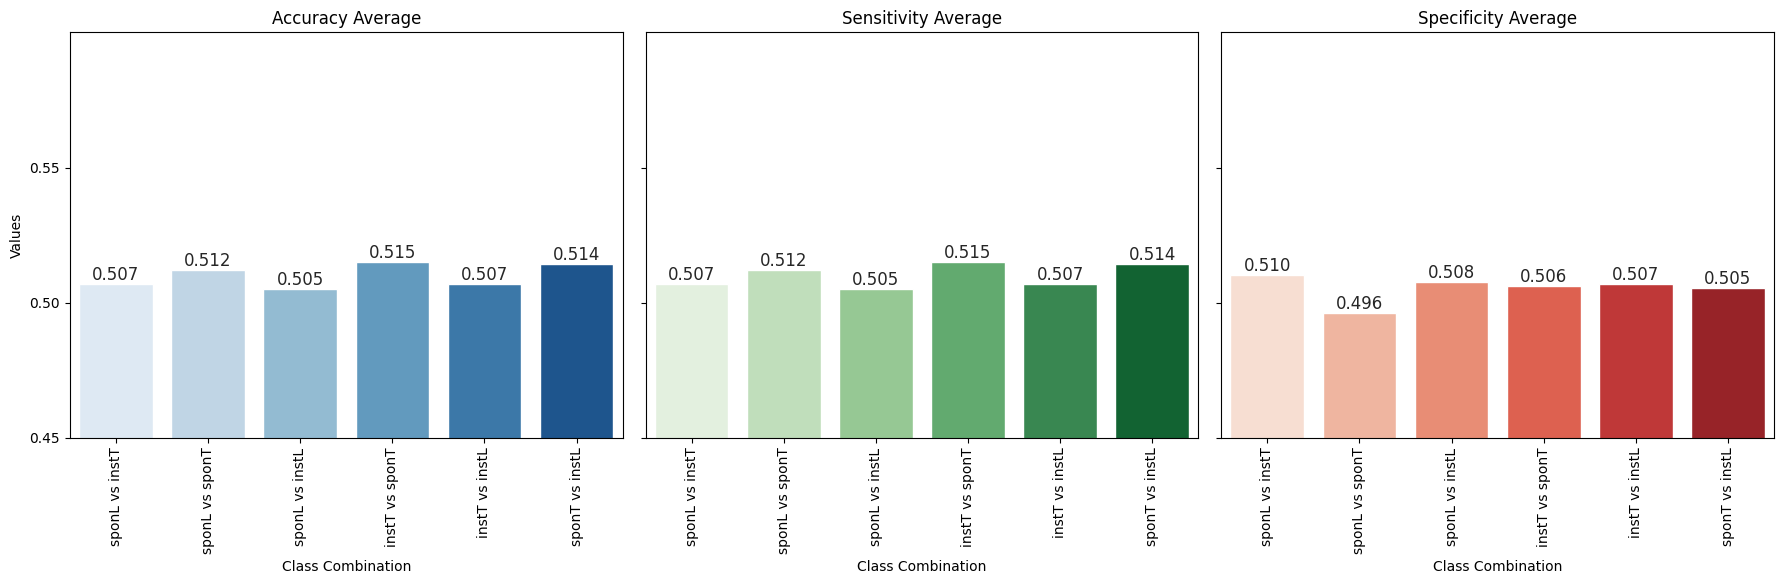

In [91]:
plot_metrics(results_4class_describe)

**Selected Top 4 channels with accuracy greater than 0.5**

In [92]:
print("Top channels with accuracy greater than 0.5")
for c in class_list:
    print(c)
    d=filter_results(results_4class, c, 0.5)
    print(d['Channel'].tolist()[:4])  #4 for top 4 channels. To see all channels with Accuracy>0.5, drop the value

Top channels with accuracy greater than 0.5
sponL vs instT
[2, 7, 13, 20]
sponL vs sponT
[1, 11]
sponL vs instL
[1, 6, 7, 8]
instT vs sponT
[1, 3, 4, 6]
instT vs instL
[2, 3, 5, 7]
sponT vs instL
[1, 2, 3, 4]


Let us plot these channels on a 2-D brain map to visualize the electrode arrangement.

In [93]:
def plot_selected_channels_on_brain(top_channels, ch_names):
    """
    Visualize selected EEG channels on a brain model.

    Parameters:
    - top_channels: List of selected channel indices
    - ch_names: List of channel names (as strings)
    """
    # Create an MNE Info object with standard channel positions
    info = mne.create_info(ch_names=ch_names, sfreq=250.0, ch_types='eeg')

    # Create a montage (standard 10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    info.set_montage(montage)

    # Create dummy data to highlight channels
    data = np.zeros(len(info.ch_names))
    data[top_channels] = 1  # Mark the selected channels

    # Set the channel names for the selected channels
    top_channel_names = [ch_names[idx] for idx in top_channels]

    # Create a mask to highlight the selected channels
    mask = np.zeros(len(info.ch_names), dtype=bool)
    mask[top_channels] = True

    # Plot the topomap for the selected channels
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    mne.viz.plot_topomap(data, info, mask=mask, mask_params=dict(marker='o', markeredgewidth=2, color='b'),
                         names=top_channel_names, axes=ax, show=False)

    # Highlight selected channels
    ax.set_title('Selected Channels')
    plt.show()


In [94]:
clist=[ch_names.tolist()[i][0] for i in range(len(ch_names))]

In [95]:
clist[0]

'F7'

sponL vs instT
Top channels (Accuracy>0.5, Max: 4 channels): [2, 7, 13, 20]


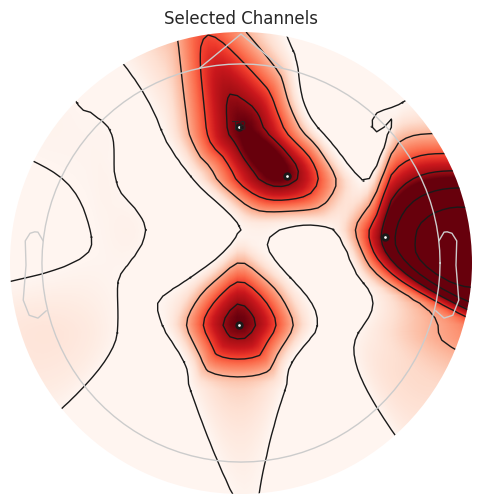

sponL vs sponT
Top channels (Accuracy>0.5, Max: 4 channels): [1, 11]


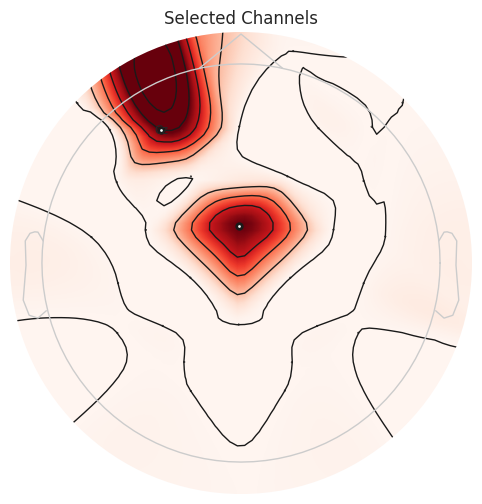

sponL vs instL
Top channels (Accuracy>0.5, Max: 4 channels): [1, 6, 7, 8]


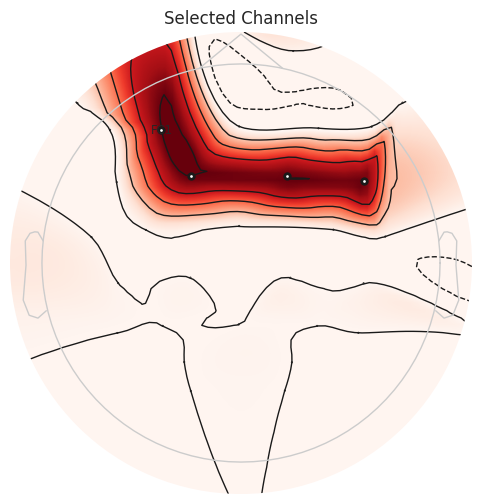

instT vs sponT
Top channels (Accuracy>0.5, Max: 4 channels): [1, 3, 4, 6]


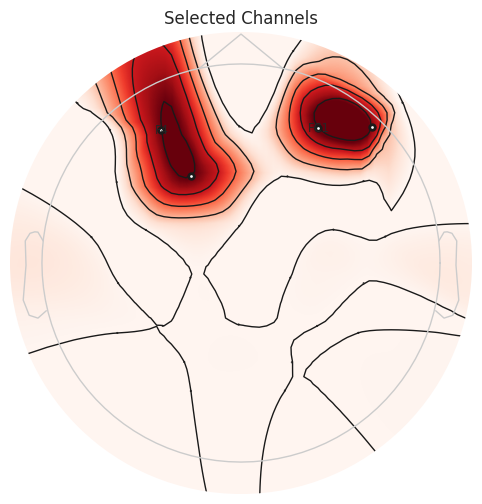

instT vs instL
Top channels (Accuracy>0.5, Max: 4 channels): [2, 3, 5, 7]


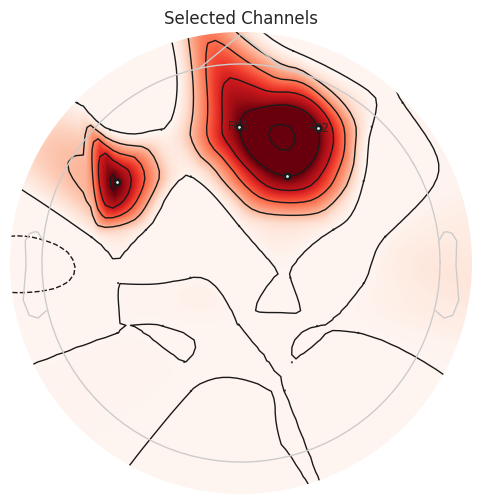

sponT vs instL
Top channels (Accuracy>0.5, Max: 4 channels): [1, 2, 3, 4]


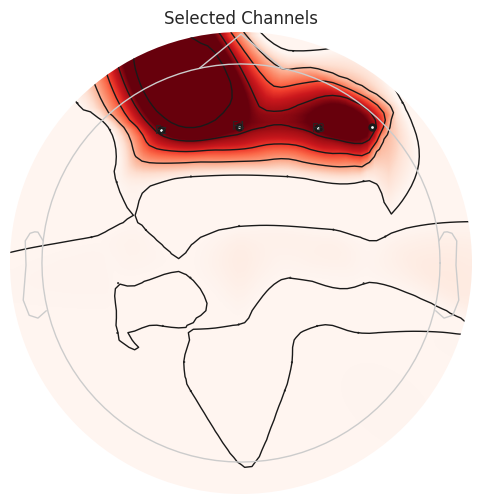

In [96]:
for c in class_list:
    print(c)
    d=filter_results(results_4class, c, 0.5)
    top_4=d['Channel'].tolist()[:4]
    print(f'Top channels (Accuracy>0.5, Max: 4 channels): {top_4}')
    plot_selected_channels_on_brain(d['Channel'].tolist()[:4], clist )

## **2 Class Analysis**





In [97]:
results_2class

,Channel,Class Combination,Accuracy,Accuracy Variance,Sensitivity,Specificity
0,1,innocent vs unknown,0.579439,0.001738,0.579439,0.506304
1,1,innocent vs guilty,0.496311,0.000381,0.496311,0.496201
2,1,unknown vs guilty,0.571351,0.000766,0.571351,0.515873
3,2,innocent vs unknown,0.470271,0.006872,0.470271,0.491673
4,2,innocent vs guilty,0.512488,0.000103,0.512488,0.512525
...,...,...,...,...,...,...
85,29,innocent vs guilty,0.502606,0.000348,0.502606,0.502508
86,29,unknown vs guilty,0.524852,0.010135,0.524852,0.497518
87,30,innocent vs unknown,0.451945,0.004535,0.451945,0.502154
88,30,innocent vs guilty,0.506202,0.000585,0.506202,0.506158


**Filtering for data with accuracy>0.5:**

In [98]:
def filter_results(df, c=None, accuracy=0):
    filtered_df = df[(df['Class Combination'] == c) & (df['Accuracy'] >= accuracy)]
    return filtered_df

filter_results(results_2class, 'innocent vs guilty', 0.5)

,Channel,Class Combination,Accuracy,Accuracy Variance,Sensitivity,Specificity
4,2,innocent vs guilty,0.512488,0.000103,0.512488,0.512525
7,3,innocent vs guilty,0.501166,0.000185,0.501166,0.501237
13,5,innocent vs guilty,0.500093,0.000264,0.500093,0.499900
19,7,innocent vs guilty,0.506921,0.000101,0.506921,0.506953
22,8,innocent vs guilty,0.504397,0.000104,0.504397,0.504332
37,13,innocent vs guilty,0.514275,0.000478,0.514275,0.514280
43,15,innocent vs guilty,0.501890,0.000236,0.501890,0.501967
46,16,innocent vs guilty,0.500449,0.000097,0.500449,0.500454
52,18,innocent vs guilty,0.507999,0.000882,0.507999,0.508041
55,19,innocent vs guilty,0.500808,0.000048,0.500808,0.500876


In [ ]:
class_list=results_2class['Class Combination'].unique().tolist()
class_list

['innocent vs unknown', 'innocent vs guilty', 'unknown vs guilty']

In [ ]:
i=1  # Modify i to filter for different combination as per class list defined above, with index starting from 0, used i=2 for guilty vs innocent
print(class_list[i])
r=filter_results(results_2class, class_list[i], 0.5)  #Accuracy is set to 0.5, Modify if needed
print(f'Accuracy Average: {r["Accuracy"].mean()}')
print(f'Accuracy Variance: {r["Accuracy Variance"].mean()}')
print(f'Sensitivity Average: {r["Sensitivity"].mean()}')
print(f'Specificity Average: {r["Specificity"].mean()}')
r

innocent vs guilty
Accuracy Average: 0.5065581071946751
Accuracy Variance: 0.00032461938504061864
Sensitivity Average: 0.5065581071946751
Specificity Average: 0.5065448716295781


,Channel,Class Combination,Accuracy,Accuracy Variance,Sensitivity,Specificity
4,2,innocent vs guilty,0.512488,0.000103,0.512488,0.512525
7,3,innocent vs guilty,0.501166,0.000185,0.501166,0.501237
13,5,innocent vs guilty,0.500093,0.000264,0.500093,0.499900
19,7,innocent vs guilty,0.506921,0.000101,0.506921,0.506953
22,8,innocent vs guilty,0.504397,0.000104,0.504397,0.504332
37,13,innocent vs guilty,0.514275,0.000478,0.514275,0.514280
43,15,innocent vs guilty,0.501890,0.000236,0.501890,0.501967
46,16,innocent vs guilty,0.500449,0.000097,0.500449,0.500454
52,18,innocent vs guilty,0.507999,0.000882,0.507999,0.508041
55,19,innocent vs guilty,0.500808,0.000048,0.500808,0.500876


In [ ]:
data={
    'Class Combination': [comb for comb in class_list],
    'Accuracy Average': [filter_results(results_2class, class_list[i], 0.5)["Accuracy"].mean() for i in range(len(class_list))],
    'Accuracy Variance': [filter_results(results_2class, class_list[i], 0.5)["Accuracy Variance"].mean() for i in range(len(class_list))],
    'Sensitivity Average':[filter_results(results_2class, class_list[i], 0.5)["Sensitivity"].mean() for i in range(len(class_list))],
    'Specificity Average': [filter_results(results_2class, class_list[i], 0.5)["Specificity"].mean() for i in range(len(class_list))]
}

results_2class_describe=pd.DataFrame(data)

In [ ]:
results_2class_describe

,Class Combination,Accuracy Average,Accuracy Variance,Sensitivity Average,Specificity Average
0,innocent vs unknown,0.572892,0.002396,0.572892,0.504501
1,innocent vs guilty,0.506558,0.000325,0.506558,0.506545
2,unknown vs guilty,0.567010,0.002486,0.567010,0.504477


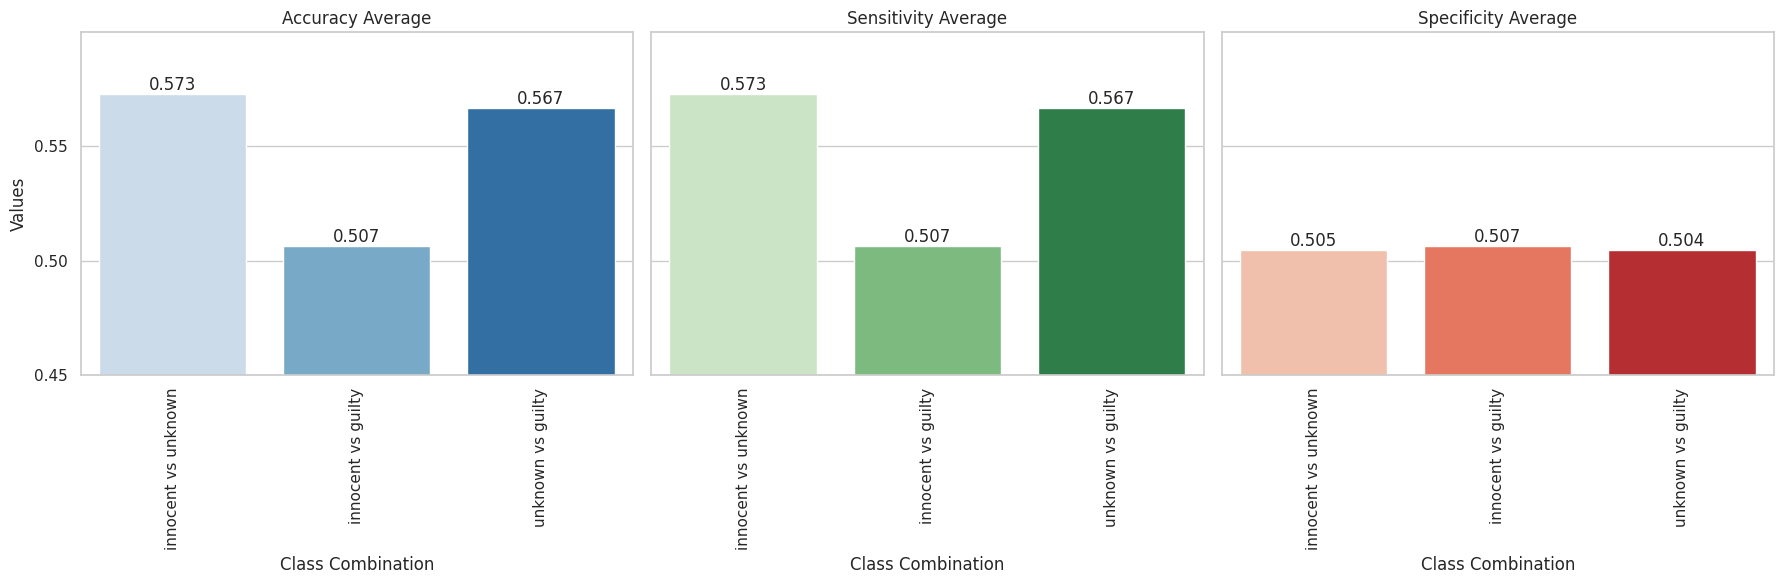

In [ ]:
plot_metrics(results_2class_describe)

**Selected Top 4 channels with accuracy greater than 0.5**

In [ ]:
print("Top channels with accuracy greater than 0.5")
for c in class_list:
    print(c)
    d=filter_results(results_2class, c, 0.5)
    print(d['Channel'].tolist()[:4])  #4 for top 4 channels. To see all channels with Accuracy>0.5, drop the value

Top channels with accuracy greater than 0.5
innocent vs unknown
[1, 3, 4, 5]
innocent vs guilty
[2, 3, 5, 7]
unknown vs guilty
[1, 2, 3, 4]


innocent vs guilty
Top channels (Accuracy>0.5, Max: 4 channels): [2, 3, 5, 7]


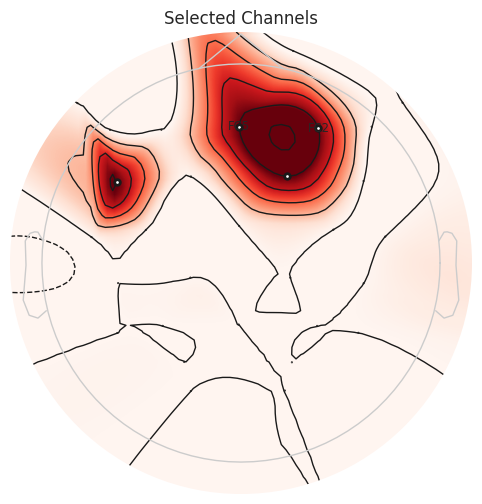

In [ ]:
c=class_list[1]
print(c)
d=filter_results(results_2class, c, 0.5)
top_4=d['Channel'].tolist()[:4]
print(f'Top channels (Accuracy>0.5, Max: 4 channels): {top_4}')
plot_selected_channels_on_brain(d['Channel'].tolist()[:4], clist )